

**Problem Statement:**

The goal is to build and evaluate econometric models (e.g., ARIMA, GARCH, VAR) and machine learning models (e.g., XGBoost, LSTM, Random Forest) for predicting the prices of precious metals, specifically gold, silver, and crude oil. After evaluating the performance of these models, Code will automatically select best performing mofles  for hybrid model creation to enhance predictive accuracy for these commodities.

The study will leverage market data, including interest rates, inflation rates, GDP, GDP-to-debt ratios, ETF prices, and both historical and live sentiment data from news feeds. While this framework can be adapted for modeling any precious metal, the current focus will be on these three commodities.

**This study will provide  a unified hybrid framework that adapts to any commodity type and automatically selects and combines the best models accordingly.**

Below Code will train and genertae model based on histrical data.

Input : Commodity Name (GOLD or SILVER or CRUDE_OIL)

Output : Save best hybrid model for realtime prediction

##### Sourcing Key Libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import os
import itertools
import requests
import yfinance as yf
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
#from arch import arch_model
from transformers import pipeline
#from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Define constant Variables

In [2]:
# constant values
# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'
# API Key for Alpha Vantage (Replace with your actual key)
API_KEY_alpha = "3J4EGZCB0D7UT9WG"
# genertae your APi key from here: https://www.alphavantage.co/

#update the below code for any new precious Metal

data_ticker_map = {
            'GOLD' : 'GC=F',
            'SILVER': 'SI=F',
            'CRUDE_OIL': 'CL=F'}

data_file_mapping = {
            'GOLD' : 'Data/Historical_Gold_data_April.csv',
           'SILVER': 'Data/Historical_Silver_data_April.csv',
           'CRUDE_OIL': 'Data/Historical_Crude_oil_data_April.csv',}

Live_Sentiments_file_name = 'Live_Sentiments.csv'
Live_Sentiments_file_dir = 'Sentiments'
Historical_Sentiments_file_name = 'Historical_Sentiments.csv'
Historical_Sentiments_file_dir = 'Sentiments'

best_models_dir = {'GOLD': 'Models/GOLD_MODELS', 'SILVER' : 'Models/SILVER_MODELS', 'CRUDE_OIL': 'Models/CRUDE_OIL_MODELS'}
hybrid_models_dir = {'GOLD': 'Models/GOLD_HYBRID_MODELS', 'SILVER' : 'Models/SILVER_HYBRID_MODELS', 'CRUDE_OIL': 'Models/CRUDE_OIL_HYBRID_MODELS'}
hybrid_meta_models_dir = {'GOLD': 'Models/GOLD_HYBRID_MODELS/Meta', 'SILVER' : 'Models/SILVER_HYBRID_MODELS/Meta', 'CRUDE_OIL': 'Models/CRUDE_OIL_HYBRID_MODELS/Meta'}

### Enter Commodity Name for which you want to predict Price EX: GOLD, SILVER, CRUDE OIL etc

In [3]:
commodity = input('Enter the Commodity Name')
filename =  data_file_mapping.get(commodity)

Enter the Commodity Name CRUDE_OIL


## Step 1 : Data Sourcing

### Step 1.1: Historical Data Sourcing

##### Yahoo finance is not reliable and having issues, download data from 2003-01-01 - 2025-03-15 via yf api.

##### Define function to download Historical data 

In [4]:
# Function to download historical price data
def download_price_data(ticker, start='2020-01-01', end='2025-04-05'):
    # Download the data
    data = yf.download(ticker, start=start, end=end)
    
    # Reset index to turn 'Date' into a regular column
    data.reset_index(inplace=True)
    
    # Flatten the columns if there are multiple levels
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    
    # Select necessary columns only
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# Load or download data for each commodity
def load_or_download_data(ticker, filename):
    if os.path.exists(filename):
        # Read the CSV, treating the first row as the header
        data = pd.read_csv(filename, header=0)
        
        # Convert 'Date' column to datetime format, and handle parsing errors
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
        
        # Remove any rows where 'Date' could not be parsed and resulted in NaT
        data = data.dropna(subset=['Date'])
    else:
        # Download the data
        data = download_price_data(ticker)
        
        # Save to CSV with a single header row
        data.to_csv(filename, index=False)
    
    # Ensure the 'Close' column is numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    
    return data


In [5]:
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')
commodity_data = load_or_download_data(ticker, filename)

Loading from Historical file id Data available in file : Data/Historical_Crude_oil_data_April.csv
Ticker code for CRUDE_OIL : CL=F


In [6]:
commodity_data

,Date,Open,High,Low,Close,Volume
0,2020-01-02,61.599998,61.599998,60.639999,61.180000,486873
1,2020-01-03,61.180000,64.089996,61.130001,63.049999,885861
2,2020-01-06,63.709999,64.720001,62.639999,63.270000,724236
3,2020-01-07,62.910000,63.150002,62.110001,62.700001,582649
4,2020-01-08,62.840000,65.650002,59.150002,59.610001,1205710
...,...,...,...,...,...,...
1318,2025-03-31,69.430000,71.830002,68.809998,71.480003,313087
1319,2025-04-01,71.389999,72.099998,71.029999,71.199997,272832
1320,2025-04-02,71.199997,72.279999,70.589996,71.709999,286501
1321,2025-04-03,70.379997,70.410004,65.980003,66.949997,459238


### 1.2 Sourcing Market data

#### 1.2.1 GDP data

##### Define function which will convert Yearly GDP data to daily GDP data

In [7]:
def expand_gdp_to_daily(gdp_df):
    daily_gdp = []
    for index, row in gdp_df.iterrows():
        month_start = row['Date']
        value = row['Value']
        month_days = pd.date_range(start=month_start, end=month_start + pd.offsets.MonthEnd(0), freq='D')
        for day in month_days:
            daily_gdp.append({'Date': day, 'Value': value})
    return pd.DataFrame(daily_gdp)


def preprocess_gdp_data(gdp_data):
    gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
    return expand_gdp_to_daily(gdp_data)


def fetch_world_bank_data(indicator, country='USA', start_year='2003', end_year='2024'):
    url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start_year}:{end_year}&format=json'
    try:
        response = requests.get(url)
        data = response.json()
        if len(data) < 2 or 'message' in data[1]:
            print("No data found for the specified parameters.")
            return None
        df = pd.json_normalize(data[1])
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= f'{start_year}-01-01') & (df['date'] <= f'{end_year}-12-31')]
        df = df[['date', 'value']]
        df.columns = ['Date', 'Value']
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None


In [8]:
############### sourcing world GDP data #################################################
gdp_data = fetch_world_bank_data('NY.GDP.MKTP.CD', country='USA', start_year='2003', end_year='2024')
daily_gdp_data = preprocess_gdp_data(gdp_data)
daily_gdp_data.rename(columns={'Value':'GDP'},inplace=True)
daily_gdp_data

,Date,GDP
0,2023-01-01,27720709000000
1,2023-01-02,27720709000000
2,2023-01-03,27720709000000
3,2023-01-04,27720709000000
4,2023-01-05,27720709000000
...,...,...
646,2003-01-27,11456450000000
647,2003-01-28,11456450000000
648,2003-01-29,11456450000000
649,2003-01-30,11456450000000


#### 1.2.2 Interest rate data

In [9]:

############## Sourcing Interest rate data ################################
from fredapi import Fred

# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'

# Initialize the FRED API
fred = Fred(api_key=api_key)

# Fetch the Federal Funds Rate data (you can change this to any other indicator)
# Federal Funds Rate is often identified by the FRED ID 'FEDFUNDS'
interest_rate_data = fred.get_series('FEDFUNDS' ,start_date='2003-01-01')

# Convert the data into a DataFrame for better handling
interest_rate_df = pd.DataFrame(interest_rate_data)
interest_rate_df.columns = ['Interest_rates']

# Reset the index to have 'Date' as a column
interest_rate_df.reset_index(inplace=True)

import pandas as pd

# Assuming `interest_rate_df` already exists with 'Date' and 'Interest_rates' columns

# Convert 'Date' column to datetime format if it’s not already
interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['index'])
interest_rate_df.drop(columns=['index'], inplace=True)  # Drop the old index column if needed

# Create a date range for every day from the start to the end of the interest rate data
start_date = interest_rate_df['Date'].min()
end_date = interest_rate_df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_interest_rate_df = pd.DataFrame({'date': date_range})

# Add a 'month' and 'year' column to `interest_rate_df` for easy merging
interest_rate_df['year'] = interest_rate_df['Date'].dt.year
interest_rate_df['month'] = interest_rate_df['Date'].dt.month

# Merge monthly data with daily data on matching 'year' and 'month'
daily_interest_rate_df['year'] = daily_interest_rate_df['date'].dt.year
daily_interest_rate_df['month'] = daily_interest_rate_df['date'].dt.month

# Perform a left join on 'year' and 'month' columns
daily_interest_rate_df = daily_interest_rate_df.merge(
    interest_rate_df[['year', 'month', 'Interest_rates']],
    on=['year', 'month'],
    how='left'
)

# Drop the extra columns, keep only 'date' and 'Interest_rates'
daily_interest_rate_data = daily_interest_rate_df[['date', 'Interest_rates']]
daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)
daily_interest_rate_data


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20476\1493415932.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)


,Date,Interest_rates
0,1954-07-01,0.80
1,1954-07-02,0.80
2,1954-07-03,0.80
3,1954-07-04,0.80
4,1954-07-05,0.80
...,...,...
25807,2025-02-25,4.33
25808,2025-02-26,4.33
25809,2025-02-27,4.33
25810,2025-02-28,4.33


#### 1.2.3 GDP to Debt data

In [10]:
################## GDP to Debt DATA ###############################
import wbdata
import pandas as pd
import datetime

# Set the start and end dates for the data
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# List of indicators to retrieve (Government Debt to GDP ratio)
indicators = {'GC.DOD.TOTL.GD.ZS': 'Government Debt to GDP'}

# Fetch data from the World Bank API for the USA
government_debt_data = wbdata.get_dataframe(indicators, country='USA')

# Fill missing values in `Government Debt to GDP` with 0
government_debt_data['Government Debt to GDP'] = government_debt_data['Government Debt to GDP'].fillna(0)

# Reset index to make `date` a regular column and convert it to datetime
government_debt_data.reset_index(inplace=True)
government_debt_data['date'] = pd.to_datetime(government_debt_data['date'])

# Add a 'year' column to `government_debt_data` to help with mapping
government_debt_data['year'] = government_debt_data['date'].dt.year

# Create a dictionary for quick lookup of Debt to GDP per year
debt_to_gdp_dict = government_debt_data.set_index('year')['Government Debt to GDP'].to_dict()

# Create a date range for every day from the start to the end date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_debt_data = pd.DataFrame({'date': date_range})

# Map each date in `daily_debt_data` to the corresponding Debt to GDP value for that year
daily_debt_data['DebtToGDP'] = daily_debt_data['date'].dt.year.map(debt_to_gdp_dict)
daily_debt_data.rename(columns={'date':'Date'},inplace=True)

daily_debt_data

,Date,DebtToGDP
0,2000-01-01,33.267642
1,2000-01-02,33.267642
2,2000-01-03,33.267642
3,2000-01-04,33.267642
4,2000-01-05,33.267642
...,...,...
8397,2022-12-28,110.385332
8398,2022-12-29,110.385332
8399,2022-12-30,110.385332
8400,2022-12-31,110.385332


#### 1.2.4 Inflation data

In [11]:
############## inflation data #################
# Get historical CPI data (Consumer Price Index) to calculate inflation
cpi_data = fred.get_series('CPIAUCSL', start_date='2003-01-01')



# Convert the data into a DataFrame for better handling
Inflation_data = pd.DataFrame(interest_rate_data)
Inflation_data.columns = ['Inflation_rate']

# Reset the index to have 'Date' as a column
Inflation_data.reset_index(inplace=True)
Inflation_data.rename(columns={'index':'Date'},inplace=True)
# Print the first few rows
Inflation_data

,Date,Inflation_rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
844,2024-11-01,4.64
845,2024-12-01,4.48
846,2025-01-01,4.33
847,2025-02-01,4.33


#### 1.2.5 ETF data

In [12]:
################ Gold ETF data ###########################################
import requests
import pandas as pd

# Fetch ETF data from FRED API
def fetch_fred_etf_data(series_id, api_key, start_date='2003-01-01', end_date='2024-11-01'):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'
    response = requests.get(url)
    data = response.json()
    
    # Print the entire JSON response for inspection
    print("Full JSON response:", data)
    
    # Check for errors in the JSON response
    if "observations" not in data:
        print("Error: 'observations' key not found in the response. Check the series ID or API request.")
        return None
    
    # Parse JSON data into a DataFrame
    etf_df = pd.DataFrame(data['observations'])
    etf_df['Date'] = pd.to_datetime(etf_df['date'])
    etf_df['Date'] = etf_df['Date'].dt.tz_localize(None).dt.date 
    etf_df['value'] = pd.to_numeric(etf_df['value'], errors='coerce')
    etf_df.set_index('Date', inplace=True)
    
    return etf_df

# Example usage
api_key = 'a27b910873da479a5561ea08035a6c79'
series_id = 'INTDSRUSM193N'  # Replace with a valid series ID from FRED
etf_data = fetch_fred_etf_data(series_id, api_key)


etf_data.rename(columns={'value':'ETF_Value'},inplace=True)
# Only print if data retrieval was successful
if etf_data is not None:
    print(etf_data.head())

Full JSON response: {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'observation_start': '2003-01-01', 'observation_end': '2024-11-01', 'units': 'lin', 'output_type': 1, 'file_type': 'json', 'order_by': 'observation_date', 'sort_order': 'asc', 'count': 224, 'offset': 0, 'limit': 100000, 'observations': [{'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-01-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-02-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-03-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-04-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-05-01', 'value': '2.25'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'date': '2003-06-01', 'value': '2'}, {'realtime_start': '2025-04-04', 'realtime_end': '2025-04-04', 'd

#### Step 1.3 : Sourcing Sentiment Data and Apply BERT

#### Sourcing Live Sentiments

In [13]:
import requests
import pandas as pd
from transformers import pipeline
from datetime import datetime, timedelta
#reading live sentiments
# API KEY: https://newsapi.org/register/success

# Function to fetch news from NewsAPI (replace with your API key)
API_KEY = "ca5eb0d931a345609fc85ed9affd48d5"
NEWS_API_URL = "https://newsapi.org/v2/everything"

def fetch_news(query, language="en", page_size=100):
    params = {
        "q": query,
        "language": language,
        "apiKey": API_KEY,
        "pageSize": page_size,
    }
    response = requests.get(NEWS_API_URL, params=params)
    data = response.json()
    
    if data.get("status") == "ok":
        articles = data.get("articles", [])
        return [(article["publishedAt"], article["title"]) for article in articles]
    else:
        print("Error fetching news:", data)
        return []

# Function to analyze sentiment using FinBERT
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")
#sentiment_pipeline = pipeline('sentiment-analysis',  model="google-bert/bert-base-uncased")

def analyze_sentiment(texts):
    sentiments = sentiment_pipeline(texts, truncation=True)
    return [sent["label"] for sent in sentiments]

# Fetch and analyze news sentiment
def get_gold_sentiment():
    news_data = fetch_news(commodity)
    
    if not news_data:
        return pd.DataFrame()
    
    df = pd.DataFrame(news_data, columns=["Date", "Headline"])
    df["Sentiment"] = analyze_sentiment(df["Headline"].tolist())
    df.to_csv("gold_sentiment_data.csv", index=False)
    return df



#### Apply Sentiment analysis on Live data and save them in disk

In [14]:
# Save the new data
import os
Live_Sentiments_file = os.path.join(Live_Sentiments_file_dir, commodity.upper(), Live_Sentiments_file_name)
if os.path.exists(Live_Sentiments_file):
        sentiment_df =  pd.read_csv(Live_Sentiments_file)  # File does not exist
else:
    # Fetch sentiment data
    sentiment_df = get_gold_sentiment()
    sentiment_df.to_csv(Live_Sentiments_file, index=False)
print(sentiment_df.head())
sentiment_df['Sentiment_score'] = sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
print(sentiment_df.head())

# Add sentiment data back to the news_df
sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
live_sentiments_df = sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
# # Print out the resulting dataframe
# print(news_df[['Date', 'Title', 'Sentiment']].head())

# Convert Date column to datetime and add a range of days around each event
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])



live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'], errors='coerce')
live_sentiments_df['Date'] = live_sentiments_df['Date'].dt.tz_localize(None).dt.date 
live_sentiments_df.head()

                   Date                                           Headline  \
0  2025-04-04T13:30:00Z  Are Tariffs About to Slam the Brakes on Oil De...   

  Sentiment  
0  negative  
                   Date                                           Headline  \
0  2025-04-04T13:30:00Z  Are Tariffs About to Slam the Brakes on Oil De...   

  Sentiment  Sentiment_score  
0  negative               -1  


,Date,Headline,Sentiment,Sentiment_score
0,2025-04-04,Are Tariffs About to Slam the Brakes on Oil De...,negative,-1


#### Load Historical Sentiment data

In [15]:
Historical_Sentiments_file = os.path.join(Historical_Sentiments_file_dir, commodity.upper(), Historical_Sentiments_file_name)
#Detect Invalid Dates
def is_invalid_date(date_str):
    try:
        pd.to_datetime(date_str, format="%d-%m-%Y", errors="raise")
        return False  # Valid date
    except:
        return True   # Invalid date



if os.path.exists(Historical_Sentiments_file) and commodity.upper()=="GOLD":
        historical_news_df =  pd.read_csv(Historical_Sentiments_file)  # File does not exist
        print(historical_news_df)
elif commodity.upper()=="GOLD" :
    # Fetch sentiment data
    historical_sentiment_data = pd.read_csv("C:/Users/Lenovo/OneDrive/Desktop/War/code/data/gold_historical_sentiments.csv", usecols=["Dates","Price Sentiment", "News"])
    historical_sentiment_data = historical_sentiment_data[~historical_sentiment_data["Dates"].astype(str).apply(is_invalid_date)]
    
    
    # Add sentiment data back to the news_df
    # # Print out the resulting dataframe
    # print(news_df[['Date', 'Title', 'Sentiment']].head())
    historical_news_df = historical_sentiment_data[['Dates', 'News', 'Price Sentiment', 'Sentiment_score']]
    historical_news_df.rename(columns = {'News':'Headline', 'Dates':'Date', 'Price Sentiment':'Sentiment'}, inplace = True)
    
    # Convert Date column to datetime and add a range of days around each event
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'], errors='coerce')
    historical_news_df['Date'] = historical_news_df['Date'].dt.tz_localize(None).dt.date 

    historical_news_df = historical_news_df[['Date','Headline']]
    historical_news_df["Sentiment_score"] = analyze_sentiment(historical_news_df["Headline"].tolist(), batch_size=16)
    historical_news_df['Sentiment_score'] = historical_news_df['Sentiment_score'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
    historical_news_df.to_csv(Historical_Sentiments_file, index=False)
else:
    historical_news_df=live_sentiments_df




## Step 2 : Data Preprocessing and Cleaning

### 2.1 Null Value Treatment

In [16]:
for data in [commodity_data]:
    data.dropna(subset=['Date', 'Close'], inplace=True)

### 2.2 Converting Values to Datetime format

In [17]:
# COnvert into date format
# Historical Data
# Convert Date column in gold_data to remove timezone
commodity_data['Date'] = commodity_data['Date'].dt.tz_localize(None).dt.date 

# Market Economic Data
daily_gdp_data['Date'] = daily_gdp_data['Date'].dt.tz_localize(None).dt.date 
interest_rate_df['Date'] = interest_rate_df['Date'].dt.tz_localize(None).dt.date 
Inflation_data['Date'] = Inflation_data['Date'].dt.tz_localize(None).dt.date 
daily_debt_data['Date'] = daily_debt_data['Date'].dt.tz_localize(None).dt.date 

### 2.3 Merging all source data to final data frame

In [18]:
# Merge all dataframes on 'Date' with 'gold_data' as the base (left join)
merged_data = commodity_data.merge(daily_gdp_data, on='Date', how='left') \
                       .merge(interest_rate_df, on='Date', how='left') \
                       .merge(Inflation_data, on='Date', how='left') \
                       .merge(daily_debt_data, on='Date', how='left') \
                        .merge(etf_data[['ETF_Value']], on='Date', how='left')

merged_data.drop(columns=['year','month'],inplace=True)

In [19]:
merged_data.info()
# Print summary of missing values after imputation
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1323 non-null   object 
 1   Open            1323 non-null   float64
 2   High            1323 non-null   float64
 3   Low             1323 non-null   float64
 4   Close           1323 non-null   float64
 5   Volume          1323 non-null   int64  
 6   GDP             80 non-null     float64
 7   Interest_rates  41 non-null     float64
 8   Inflation_rate  41 non-null     float64
 9   DebtToGDP       756 non-null    float64
 10  ETF_Value       12 non-null     float64
dtypes: float64(9), int64(1), object(1)
memory usage: 113.8+ KB
Date                 0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
GDP               1243
Interest_rates    1282
Inflation_rate    1282
DebtToGDP          567
ETF_Value     

### 2.4 Processing NULL values from merged data

In [20]:

# Convert numeric columns from object type to float (if needed)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors="coerce")

# 🔹 Handle Financial Market Data (Time-series features)
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)

# 🔹 Handle Volume (Typically Skewed, Use Median)
merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)

# 🔹 Handle Economic Indicators (Use Mean or Interpolation)
econ_cols = ["GDP", "DebtToGDP", "Interest_rates", "Inflation_rate", "ETF_Value"]
for col in econ_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)  # Mean Imputation


# Print summary of missing values after imputation
print(merged_data.isnull().sum())

commodity_data=merged_data

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
GDP               0
Interest_rates    0
Inflation_rate    0
DebtToGDP         0
ETF_Value         0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20476\962026131.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20476\962026131.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Te

### 2.5 Outlier Treatment

In [21]:

# Function to identify and remove outliers using IQR
def identify_outliers(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to float, set errors to NaN
    df = df.dropna(subset=['Close'])  # Drop rows where 'Close' is NaN after conversion

    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ndf = df[(df['Close'] <= lower_bound) | (df['Close'] >= upper_bound)]
    return ndf

# Apply outlier detection to the Gold dataset
commodity_data['Close'] = pd.to_numeric(commodity_data['Close'], errors='coerce')  # Ensure 'Close' is numeric
outlier = identify_outliers(commodity_data)
outlier

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
45,2020-03-09,32.869999,34.880001,27.340000,31.129999,1774383,2.466163e+13,2.430732,2.430732,124.733177,0.25
46,2020-03-10,30.370001,35.020000,30.200001,34.360001,1064632,2.466163e+13,2.430732,2.430732,124.733177,0.25
47,2020-03-11,34.619999,36.349998,32.560001,32.980000,874646,2.466163e+13,2.430732,2.430732,124.733177,0.25
48,2020-03-12,33.070000,33.630001,30.020000,31.500000,1025036,2.466163e+13,2.430732,2.430732,124.733177,0.25
49,2020-03-13,30.770000,33.869999,30.330000,31.730000,743129,2.466163e+13,2.430732,2.430732,124.733177,0.25
...,...,...,...,...,...,...,...,...,...,...,...
624,2022-06-24,103.989998,108.580002,103.639999,107.620003,321591,2.466163e+13,2.430732,2.430732,110.385332,0.25
625,2022-06-27,107.220001,110.540001,105.599998,109.570000,282914,2.466163e+13,2.430732,2.430732,110.385332,0.25
626,2022-06-28,110.180000,112.220001,109.620003,111.760002,306748,2.466163e+13,2.430732,2.430732,110.385332,0.25
627,2022-06-29,111.860001,114.050003,109.220001,109.779999,322060,2.466163e+13,2.430732,2.430732,110.385332,0.25


In [22]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
0,2020-01-02,61.599998,61.599998,60.639999,61.180000,486873,2.135410e+13,2.430732,2.430732,124.733177,0.25
1,2020-01-03,61.180000,64.089996,61.130001,63.049999,885861,2.135410e+13,2.430732,2.430732,124.733177,0.25
2,2020-01-06,63.709999,64.720001,62.639999,63.270000,724236,2.135410e+13,2.430732,2.430732,124.733177,0.25
3,2020-01-07,62.910000,63.150002,62.110001,62.700001,582649,2.135410e+13,2.430732,2.430732,124.733177,0.25
4,2020-01-08,62.840000,65.650002,59.150002,59.610001,1205710,2.135410e+13,2.430732,2.430732,124.733177,0.25
...,...,...,...,...,...,...,...,...,...,...,...
1318,2025-03-31,69.430000,71.830002,68.809998,71.480003,313087,2.466163e+13,2.430732,2.430732,118.021316,0.25
1319,2025-04-01,71.389999,72.099998,71.029999,71.199997,272832,2.466163e+13,2.430732,2.430732,118.021316,0.25
1320,2025-04-02,71.199997,72.279999,70.589996,71.709999,286501,2.466163e+13,2.430732,2.430732,118.021316,0.25
1321,2025-04-03,70.379997,70.410004,65.980003,66.949997,459238,2.466163e+13,2.430732,2.430732,118.021316,0.25


### 2.6 Data Visulization

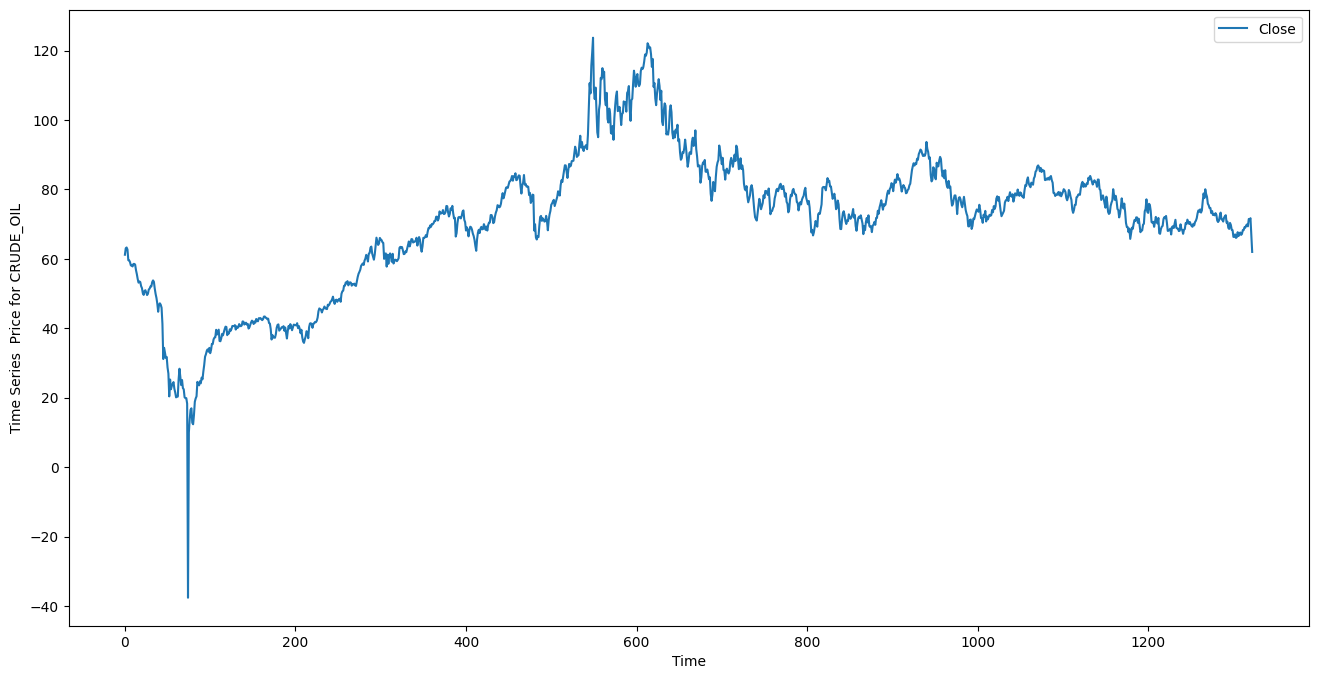

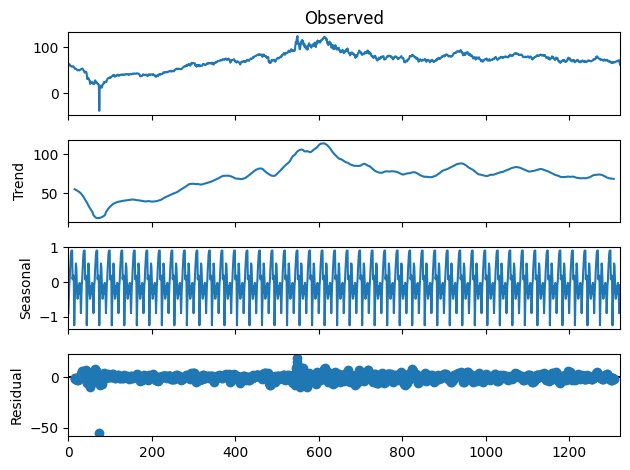

In [23]:
for commodity, data in zip([commodity,], [commodity_data,]):
    series = pd.DataFrame(data=data['Close'], columns = ['Close'] ).dropna()
    series.plot(figsize=(16,8));
    plt.ylabel(f'Time Series  Price for {commodity}')
    plt.xlabel('Time')
    result = seasonal_decompose(series.values, model = 'additive', period = 30)
    result.plot();
    plt.show()

### 2.7 Data Merging - Sentiments with Commodity Data

#### Merging Live and Histrical Sentiment data

In [24]:
live_sentiments_df = live_sentiments_df[['Date','Sentiment_score']]
historical_news_df = historical_news_df[['Date','Sentiment_score']]

In [25]:
# Convert 'Date' column to datetime format in both DataFrames
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])
historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])

# Merge the DataFrames and sort by 'Date'
sentiment_df = pd.concat([live_sentiments_df, historical_news_df], ignore_index=True).sort_values(by='Date')

# Display the first few rows
print(sentiment_df.head())


        Date  Sentiment_score
0 2025-04-04               -1
1 2025-04-04               -1


In [26]:
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'])

In [27]:
commodity_data.tail()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
1318,2025-03-31,69.430000,71.830002,68.809998,71.480003,313087,2.466163e+13,2.430732,2.430732,118.021316,0.25
1319,2025-04-01,71.389999,72.099998,71.029999,71.199997,272832,2.466163e+13,2.430732,2.430732,118.021316,0.25
1320,2025-04-02,71.199997,72.279999,70.589996,71.709999,286501,2.466163e+13,2.430732,2.430732,118.021316,0.25
1321,2025-04-03,70.379997,70.410004,65.980003,66.949997,459238,2.466163e+13,2.430732,2.430732,118.021316,0.25
1322,2025-04-04,66.639999,66.900002,60.450001,61.990002,559638,2.466163e+13,2.430732,2.430732,118.021316,0.25


### 2.8 Merging Sentiment Data with Gold Data

In [28]:
commodity_data = pd.merge(commodity_data, sentiment_df[['Date', 'Sentiment_score']], on='Date', how='left')
commodity_data.head()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2020-01-02,61.599998,61.599998,60.639999,61.180000,486873,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN
1,2020-01-03,61.180000,64.089996,61.130001,63.049999,885861,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN
2,2020-01-06,63.709999,64.720001,62.639999,63.270000,724236,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN
3,2020-01-07,62.910000,63.150002,62.110001,62.700001,582649,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN
4,2020-01-08,62.840000,65.650002,59.150002,59.610001,1205710,2.135410e+13,2.430732,2.430732,124.733177,0.25,NaN


In [29]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
-1.0    2
Name: count, dtype: int64

### 2.9 Null Treatment post sentiment merge

In [30]:
#Interpolation – Estimate Sentiment Values Based on Nearby Data
#Good for gradual sentiment changes but may not capture sudden shifts.
commodity_data['Sentiment_score'] = sentiment_df['Sentiment_score'].interpolate(method='linear')  

commodity_data['Sentiment_score'].fillna(0, inplace=True)
# Print summary of missing values after imputation
print(commodity_data.isnull().sum())

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
GDP                0
Interest_rates     0
Inflation_rate     0
DebtToGDP          0
ETF_Value          0
Sentiment_score    0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20476\1915627315.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  commodity_data['Sentiment_score'].fillna(0, inplace=True)


In [31]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    1322
-1.0       2
Name: count, dtype: int64

In [32]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2020-01-02,61.599998,61.599998,60.639999,61.180000,486873,2.135410e+13,2.430732,2.430732,124.733177,0.25,-1.0
1,2020-01-03,61.180000,64.089996,61.130001,63.049999,885861,2.135410e+13,2.430732,2.430732,124.733177,0.25,-1.0
2,2020-01-06,63.709999,64.720001,62.639999,63.270000,724236,2.135410e+13,2.430732,2.430732,124.733177,0.25,0.0
3,2020-01-07,62.910000,63.150002,62.110001,62.700001,582649,2.135410e+13,2.430732,2.430732,124.733177,0.25,0.0
4,2020-01-08,62.840000,65.650002,59.150002,59.610001,1205710,2.135410e+13,2.430732,2.430732,124.733177,0.25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1319,2025-04-01,71.389999,72.099998,71.029999,71.199997,272832,2.466163e+13,2.430732,2.430732,118.021316,0.25,0.0
1320,2025-04-02,71.199997,72.279999,70.589996,71.709999,286501,2.466163e+13,2.430732,2.430732,118.021316,0.25,0.0
1321,2025-04-03,70.379997,70.410004,65.980003,66.949997,459238,2.466163e+13,2.430732,2.430732,118.021316,0.25,0.0
1322,2025-04-04,66.639999,66.900002,60.450001,61.990002,559638,2.466163e+13,2.430732,2.430732,118.021316,0.25,0.0


## Step 3 : Feature Engineering

### 3.1 Create Features 

In [33]:
import numpy as np

def feature_engineering(df, world_bank_data=None):
    # Lagged values and moving averages
    df['lag_1'] = df['Close'].shift(1)
    df['lag_7'] = df['Close'].shift(7)
    df['lag_30'] = df['Close'].shift(30)
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    df['tomorrow_price'] = df['Close'].shift(-1)
    # Compute log returns fro GARCH
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Adding volatility features
    df['volatility_7'] = df['Close'].rolling(window=7).std()
    df['volatility_30'] = df['Close'].rolling(window=30).std()

    # #Gold prices may respond more to cumulative sentiment trends rather than individual daily sentiments. We apply a moving average to smooth fluctuations.
    # # Creating lagged sentiment features
    # df["Sentiment_Lag_1"] = df["Sentiment_score"].shift(1)
    # df["Sentiment_Lag_3"] = df["Sentiment_score"].shift(3)
    # df["Sentiment_Lag_7"] = df["Sentiment_score"].shift(7)
    # Compute rolling mean sentiment over 14-day and 30-day windows
    df["Sentiment_Rolling_14"] = df["Sentiment_score"].rolling(window=14, min_periods=1).mean()
    df["Sentiment_Rolling_30"] = df["Sentiment_score"].rolling(window=30, min_periods=1).mean()


    df.dropna(inplace=True)  # Drop NaN values after shifting and rolling
    return df


### 3.2 Apply Feature engineering on data

In [34]:
commodity_data = feature_engineering(commodity_data)

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [35]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
89,2020-05-11,24.490000,25.580000,23.670000,24.139999,179591,2.466163e+13,2.430732,2.430732,124.733177,...,21.510000,23.021428,18.413333,37.222556,25.780001,-0.024551,2.050231,11.480387,0.0,0.0
90,2020-05-12,24.490000,26.230000,24.219999,25.780001,212335,2.466163e+13,2.430732,2.430732,124.733177,...,20.090000,23.878571,18.603000,36.829222,25.290001,0.065729,1.692173,11.555797,0.0,0.0
91,2020-05-13,25.299999,26.450001,24.790001,25.290001,150864,2.466163e+13,2.430732,2.430732,124.733177,...,20.480000,24.578571,18.763333,36.409667,27.559999,-0.019190,0.771653,11.615950,0.0,0.0
92,2020-05-14,25.559999,27.959999,25.180000,27.559999,160507,2.466163e+13,2.430732,2.430732,124.733177,...,20.309999,25.007143,19.005000,36.012889,29.430000,0.085956,1.364768,11.724151,0.0,0.0
93,2020-05-15,27.639999,29.920000,27.240000,29.430000,108016,2.466163e+13,2.430732,2.430732,124.733177,...,25.320000,25.784286,19.142000,35.643222,31.820000,0.065649,2.060541,11.824075,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,2025-03-31,69.430000,71.830002,68.809998,71.480003,313087,2.466163e+13,2.430732,2.430732,118.021316,...,70.739998,69.542858,68.738667,70.827111,71.199997,0.030107,1.001379,1.872228,0.0,0.0
1319,2025-04-01,71.389999,72.099998,71.029999,71.199997,272832,2.466163e+13,2.430732,2.430732,118.021316,...,71.849998,69.960000,68.717001,70.847222,71.709999,-0.003925,0.995808,1.838436,0.0,0.0
1320,2025-04-02,71.199997,72.279999,70.589996,71.709999,286501,2.466163e+13,2.430732,2.430732,118.021316,...,72.250000,70.331429,68.699001,70.878778,66.949997,0.007137,1.104844,1.804991,0.0,0.0
1321,2025-04-03,70.379997,70.410004,65.980003,66.949997,459238,2.466163e+13,2.430732,2.430732,118.021316,...,72.570000,70.038571,68.511667,70.843778,61.990002,-0.068684,1.652528,1.676443,0.0,0.0


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of all features with 'Close'
correlation_with_close = commodity_data.corr()["Close"].sort_values(ascending=False)

# Convert to DataFrame
correlation_df = correlation_with_close.to_frame().rename(columns={"Close": "Correlation"})

correlation_df


,Correlation
Close,1.000000
Low,0.998007
High,0.997131
Open,0.994725
lag_1,0.994299
tomorrow_price,0.994265
MA_7,0.990231
lag_7,0.967335
MA_30,0.962346
MA_90,0.903265


### 3.3  Visualization of Features againts Gold Price

Text(0, 0.5, 'Inflation_rate')

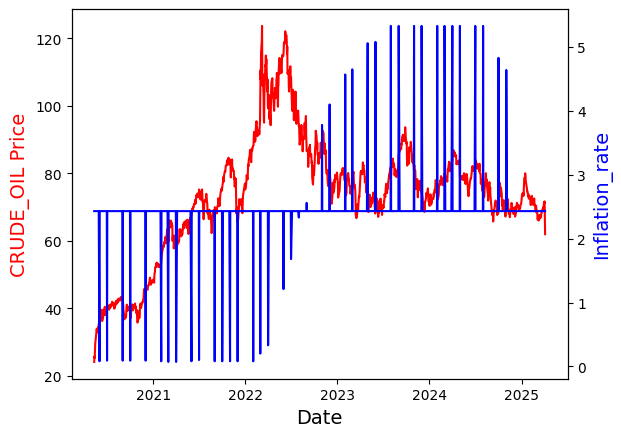

In [37]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.Inflation_rate  ,color="blue")
ax2.set_ylabel("Inflation_rate",color="blue",fontsize=14)

Text(0, 0.5, 'MA_7 ')

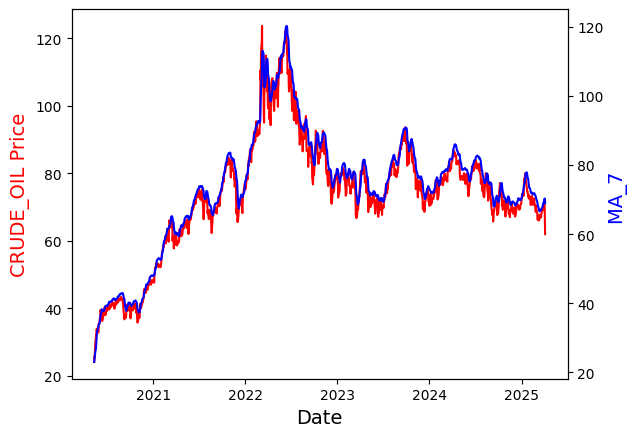

In [38]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.MA_7,color="blue")
ax2.set_ylabel("MA_7 ",color="blue",fontsize=14)

Text(0, 0.5, 'Interest_rates   ')

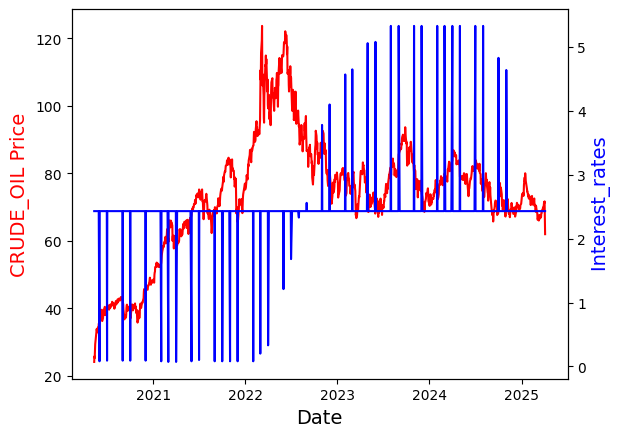

In [39]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.Interest_rates  ,color="blue")
ax2.set_ylabel("Interest_rates   ",color="blue",fontsize=14)

Text(0, 0.5, 'GDP     ')

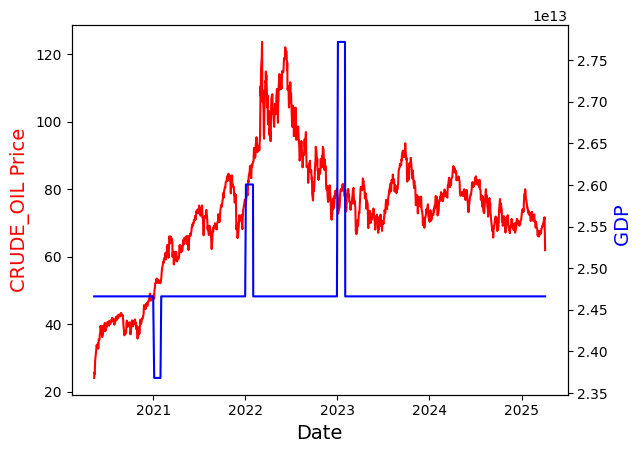

In [40]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.GDP               ,color="blue")
ax2.set_ylabel("GDP     ",color="blue",fontsize=14)

Text(0, 0.5, 'DebtToGDP')

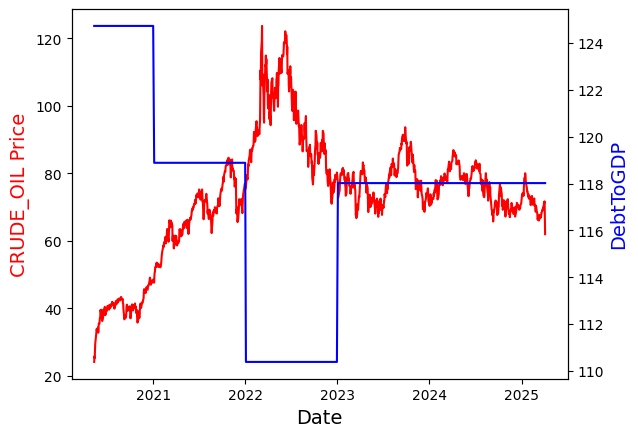

In [41]:
  
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.DebtToGDP               ,color="blue")
ax2.set_ylabel("DebtToGDP",color="blue",fontsize=14)

Text(0, 0.5, 'ETF_Value ')

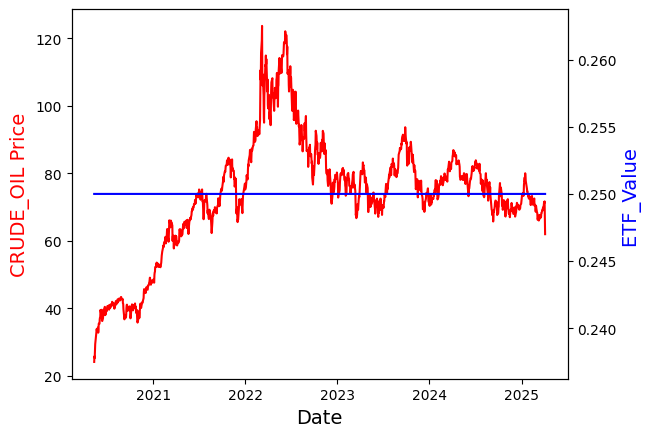

In [42]:
fig,ax = plt.subplots()
ax.plot(commodity_data.Date, commodity_data.Close, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel(f"{commodity} Price",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(commodity_data.Date, commodity_data.ETF_Value ,color="blue")
ax2.set_ylabel("ETF_Value ",color="blue",fontsize=14)

### 3.4 Seting Index of data frame is as a Date column

In [43]:
commodity_data_df = commodity_data
commodity_data_df.set_index('Date', drop=True, inplace=True)

## STEP 4 : Split and Normalize Data
### 4.1 Splitting Data into test and train data set

Train-Test Split for Time Series Data
Unlike traditional machine learning problems, time series data should not be shuffled randomly. Instead, you should split based on time:

Training Set: Data before a selected date (e.g., before 2022-01-01) or 80%
Testing Set: Data after that date (e.g., 2022-01-01 onward) or 20 %

In [44]:
import pandas as pd

# Convert index to datetime if not already
commodity_data_df.index = pd.to_datetime(commodity_data_df.index)

# Define 80-20% split based on row count
split_index = int(len(commodity_data_df) * 0.80)  
split_date = commodity_data_df.index[split_index]  

# Train-test split
train_df = commodity_data_df.loc[:split_date]  
test_df = commodity_data_df.loc[split_date:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")


Train size: (988, 23), Test size: (247, 23)


In [45]:
# Separate features and target

# Select features and target
X_train = train_df.drop(columns=['tomorrow_price', 'Close' ])
y_train = train_df['Close']
X_test = test_df.drop(columns=['tomorrow_price', 'Close'])
y_test = test_df['Close']


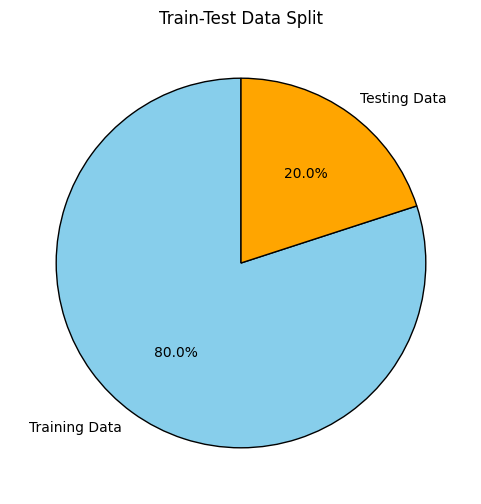

In [46]:
import matplotlib.pyplot as plt

# Compute sizes
train_size = len(train_df)
test_size = len(test_df)

# Labels and sizes
labels = ['Training Data', 'Testing Data']
sizes = [train_size, test_size]
colors = ['skyblue', 'orange']

# Create Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})

# Title
plt.title('Train-Test Data Split')
plt.show()


### 4.2 Scaling Data Properly
Econometric Models (ARIMA, GARCH, VAR):
These models work with raw data, so no need to scale.

Machine Learning Models (XGBoost, Random Forest, LSTM):
These models benefit from feature scaling to improve performance.

Scaling for ML Models
MinMax Scaling (for XGBoost, RF): Works well for tree-based models.
Standard Scaling (for LSTM): Ensures that values are normally distributed.

In [47]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)

# # Rescale y_train
# scaler_y = MinMaxScaler()
y_train_scaled = scaler_minmax.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_minmax.transform(y_test.values.reshape(-1, 1)).ravel()



#### This is how Feed Data into Different Models


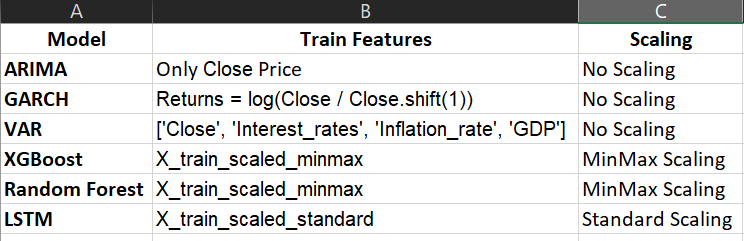

#### 4.3  Define Forcasting Function for model evaluation

In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# DataFrame to store the results
best_results_df = pd.DataFrame()

# Function to compute forecast accuracy and store the forecasted values
def forecast_accuracy(forecast, actual, Model_Object, model):
    mape = np.mean(np.abs((forecast - actual) / np.where(actual != 0, actual, np.nan))) * 100  # MAPE
    me = np.mean(forecast - actual)  # ME
    mse = np.mean((forecast - actual) ** 2)  # MSE
    mae = np.mean(np.abs(forecast - actual))  # MAE
    r2 = r2_score(actual, forecast)  # R-squared
    rmse = np.sqrt(mse)  # RMSE

    print(f"\nModel: {model}")
    print(f"ME: {me:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

    return {
        "Model": model,
        "ME": me,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R-squared": r2,
        "MAPE": mape,
        "Model_Object": Model_Object,
        "Forecasted Values": [forecast],  # Store forecasted values
        
    }


## Step 5 : MODEL BUILDING

The model-building process for forecasting commodity prices is structured into two parallel workflows: econometric models and ML & DL models,

**Econometric Models**
1. ARIMA
2. GARCH
3. VAR

   
**Machine Learning**

4. XGBOOST
5. RANDOM FOREST
6. LSTM

**Each model building below steps:**
1. Build
2. Forecast
3. evaluate
4. future forecast
5. Visulize


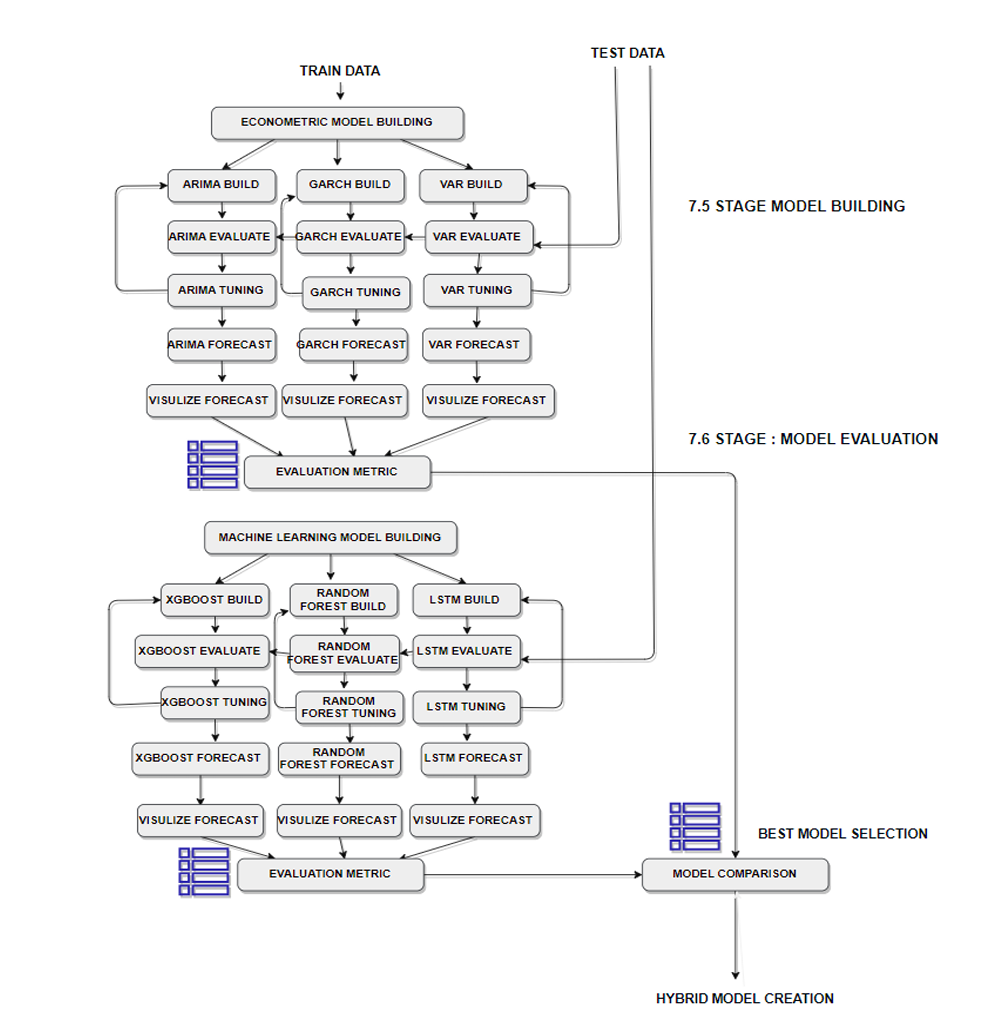

## 5.1 ARIMA Model building



#### Model 1 : RANDOM ORDER 0,1,0

In [49]:
arima_model_1 = ARIMA(y_train, order=(0,1,0))
arima_fitted_model_1 = arima_model_1.fit()  

# Forecasting the next steps
arima_forecast_results_model_1 = arima_fitted_model_1.get_forecast(steps=len(y_test))  # Get forecasted values with confidence intervals

# Extract the forecasted values
fc_model_1 = arima_forecast_results_model_1.predicted_mean

# Extract confidence intervals
conf_model_1 = arima_forecast_results_model_1.conf_int()

# Optionally, you can also get standard errors
se_model_1 = arima_forecast_results_model_1.se_mean  # Standard errors of the forecasts

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

In [50]:
# Create a DataFrame to hold the forecast results
forecast_df_model_1 = pd.DataFrame({'Forecast': fc_model_1.values}, index=y_test.index)

# Add confidence intervals to the DataFrame
forecast_df_model_1['lower_series'] = conf_model_1.iloc[:, 0].values  # Lower confidence interval
forecast_df_model_1['upper_series'] = conf_model_1.iloc[:, 1].values  # Upper confidence interval

# Print the forecast results
print(forecast_df_model_1)

             Forecast  lower_series  upper_series
Date                                             
2024-04-12  85.660004     81.801497     89.518510
2024-04-15  85.660004     80.203251     91.116756
2024-04-16  85.660004     78.976874     92.343134
2024-04-17  85.660004     77.942990     93.377017
2024-04-18  85.660004     77.032120     94.287887
...               ...           ...           ...
2025-03-31  85.660004     25.511835    145.808173
2025-04-01  85.660004     25.388200    145.931807
2025-04-02  85.660004     25.264819    146.055189
2025-04-03  85.660004     25.141689    146.178319
2025-04-04  85.660004     25.018809    146.301199

[247 rows x 3 columns]


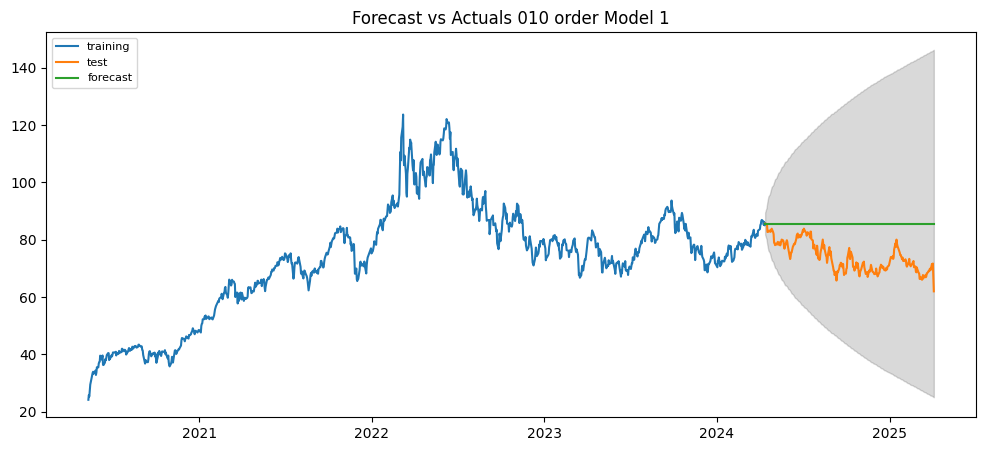

In [51]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, label='test')
plt.plot(forecast_df_model_1.Forecast, label='forecast')
plt.fill_between(forecast_df_model_1.index, forecast_df_model_1.lower_series, forecast_df_model_1.upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals 010 order Model 1')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [52]:
# Store ARIMA model results in DataFrame
results_df_arima = pd.DataFrame()
arima_metrics = forecast_accuracy(fc_model_1.values, y_test.values, arima_fitted_model_1,'ARIMA-010_model_1')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arima_metrics])], ignore_index=True)
results_df_arima


Model: ARIMA-010_model_1
ME: 11.7427, MSE: 163.9582, MAE: 11.7427, RMSE: 12.8046, R²: -5.2899, MAPE: 16.43%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,11.742716,163.958248,11.742716,12.804618,-5.28991,16.429408,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.66000366210938, 85.66000366210938, 85.660..."


### ARIMA MODEL : 2 - ORDER 1,2,2

In [53]:
# model_best = ARIMA(y_train, order=model_auto.order)  
arima_model_model_2 = ARIMA(y_train, order=(1,2,2))
arima_fitted_model_2 = arima_model_model_2.fit()  

# Forecasting the next steps
arima_forecast_results_model_2 = arima_fitted_model_2.get_forecast(steps=len(y_test))  # Get forecasted values with confidence intervals

# Extract the forecasted values
fc_model_2 = arima_forecast_results_model_2.predicted_mean

# Extract confidence intervals
conf_model_2 = arima_forecast_results_model_2.conf_int()

# Optionally, you can also get standard errors
se_model_2 = arima_forecast_results_model_2.se_mean  # Standard errors of the forecasts

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

In [54]:
# Create a DataFrame to hold the forecast results
forecast_df_model_2 = pd.DataFrame({'Forecast': fc_model_2.values}, index=y_test.index)

# Add confidence intervals to the DataFrame
forecast_df_model_2['lower_series'] = conf_model_2.iloc[:, 0].values  # Lower confidence interval
forecast_df_model_2['upper_series'] = conf_model_2.iloc[:, 1].values  # Upper confidence interval

# Print the forecast results
print(forecast_df_model_2)

              Forecast  lower_series  upper_series
Date                                              
2024-04-12   85.712119     81.858673     89.565564
2024-04-15   85.782587     80.282328     91.282845
2024-04-16   85.835494     79.113346     92.557643
2024-04-17   85.905204     78.118465     93.691942
2024-04-18   85.958837     77.261059     94.656615
...                ...           ...           ...
2025-03-31  100.598241     32.664765    168.531716
2025-04-01  100.659735     32.557655    168.761815
2025-04-02  100.721229     32.450722    168.991736
2025-04-03  100.782723     32.343965    169.221481
2025-04-04  100.844217     32.237383    169.451051

[247 rows x 3 columns]


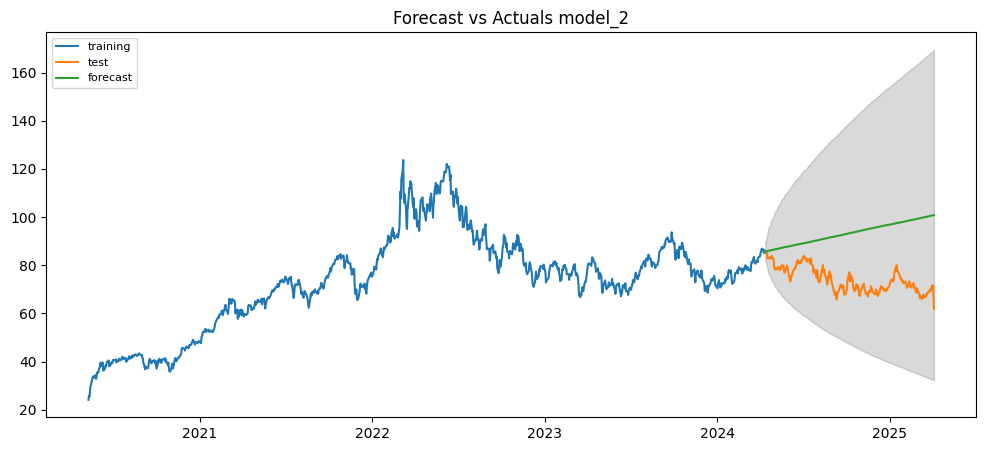

In [55]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, label='test')
plt.plot(forecast_df_model_2.Forecast, label='forecast')
plt.fill_between(forecast_df_model_2.index, forecast_df_model_2.lower_series, forecast_df_model_2.upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals model_2')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [56]:
arimametrics = forecast_accuracy(fc_model_2.values, y_test.values, arima_fitted_model_2,'ARIMA-122_model_2')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arimametrics])], ignore_index=True)
results_df_arima


Model: ARIMA-122_model_2
ME: 19.3632, MSE: 453.6631, MAE: 19.3632, RMSE: 21.2994, R²: -16.4038, MAPE: 27.09%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,11.742716,163.958248,11.742716,12.804618,-5.289910,16.429408,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.66000366210938, 85.66000366210938, 85.660..."
1,ARIMA-122_model_2,19.363164,453.663100,19.363164,21.299369,-16.403822,27.086619,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.7121188123529, 85.78258653674959, 85.8354..."


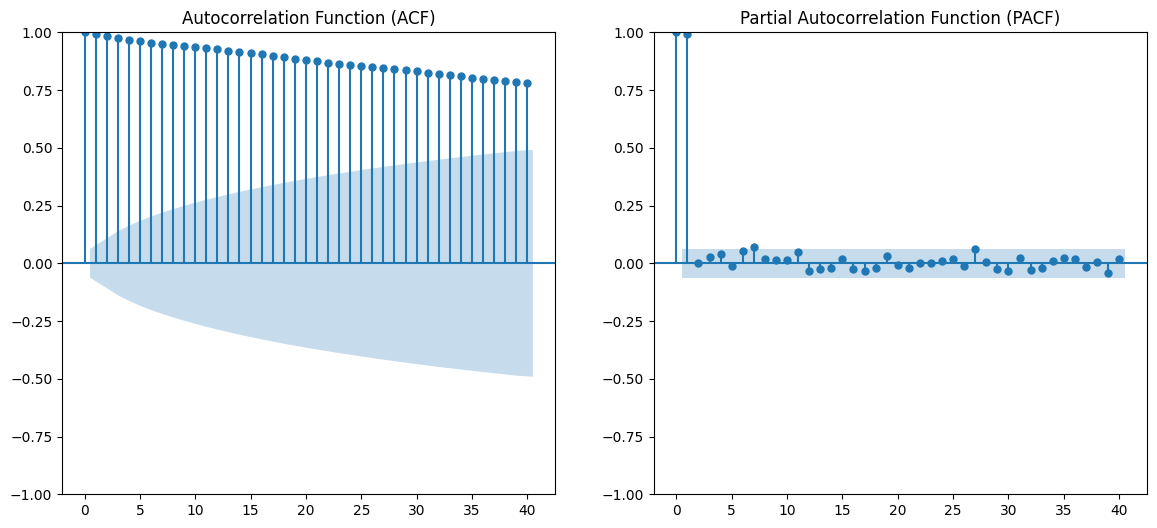

In [57]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF plot
sm.graphics.tsa.plot_acf(y_train, lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

### Run with Auto ARIMA best order 

### MODEL : 3 - AUTO ARIMA 

In [58]:
from pmdarima import auto_arima

# Auto ARIMA to find best (p, d, q)
model_auto = auto_arima(y_train, seasonal=False, stepwise=True, trace=True,max_p=10, max_q=10, d=1,  
                        information_criterion='bic')

# Best order
print("Best ARIMA order:", model_auto.order)


Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=4153.040, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=4150.886, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=4157.604, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=4157.576, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=4144.981, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=4159.009, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.937 seconds
Best ARIMA order: (0, 1, 0)


In [59]:
model_auto.order

(0, 1, 0)

In [60]:
from statsmodels.tsa.arima.model import ARIMA

# Use the best order from auto_arima
best_p, best_d, best_q = model_auto.order
arima_model_best = ARIMA(y_train, order=(best_p, best_d, best_q))
arima_fitted = arima_model_best.fit()

# Forecast
arima_forecast_results = arima_fitted.get_forecast(steps=len(y_test))

# Extract the forecasted values and confidence intervals
fc = arima_forecast_results.predicted_mean
conf = arima_forecast_results.conf_int()


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_predic

In [61]:
arimametrics = forecast_accuracy(fc.values, y_test.values, arima_fitted,'ARIMA_AUTO_model-3')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arimametrics])], ignore_index=True)
results_df_arima


Model: ARIMA_AUTO_model-3
ME: 11.7427, MSE: 163.9582, MAE: 11.7427, RMSE: 12.8046, R²: -5.2899, MAPE: 16.43%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,11.742716,163.958248,11.742716,12.804618,-5.289910,16.429408,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.66000366210938, 85.66000366210938, 85.660..."
1,ARIMA-122_model_2,19.363164,453.663100,19.363164,21.299369,-16.403822,27.086619,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.7121188123529, 85.78258653674959, 85.8354..."
2,ARIMA_AUTO_model-3,11.742716,163.958248,11.742716,12.804618,-5.289910,16.429408,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.66000366210938, 85.66000366210938, 85.660..."


### Model : 4 -ARIMA WITHOUT MICORECONOMIC FACTORS

In [62]:
# model_best = ARIMA(y_train, order=model_auto.order)  
arima_model_micro = ARIMA(y_train, order=(1,3,2)) #123 #132
arima_fitted_micro = arima_model_micro.fit()  

# Forecasting the next steps
arima_forecast_results_micro = arima_fitted_micro.get_forecast(steps=len(y_test))  # Get forecasted values with confidence intervals

# Extract the forecasted values
fc_micro = arima_forecast_results_micro.predicted_mean

# Extract confidence intervals
conf_micro = arima_forecast_results_micro.conf_int()

# Optionally, you can also get standard errors
se_micro = arima_forecast_results_micro.se_mean  # Standard errors of the forecasts

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

In [63]:
# Create a DataFrame to hold the forecast results
forecast_df_micro = pd.DataFrame({'Forecast': fc_micro.values}, index=y_test.index)

# Add confidence intervals to the DataFrame
forecast_df_micro['lower_series'] = conf_micro.iloc[:, 0].values  # Lower confidence interval
forecast_df_micro['upper_series'] = conf_micro.iloc[:, 1].values  # Upper confidence interval

# Print the forecast results
print(forecast_df_micro)

             Forecast  lower_series  upper_series
Date                                             
2024-04-12  85.601112     81.735038     89.467186
2024-04-15  85.531366     80.012924     91.049809
2024-04-16  85.461780     78.675929     92.247631
2024-04-17  85.392529     77.536091     93.248967
2024-04-18  85.323617     76.521249     94.125986
...               ...           ...           ...
2025-03-31  78.555521    -20.555032    177.666074
2025-04-01  78.567558    -20.988975    178.124092
2025-04-02  78.579934    -21.423900    178.583768
2025-04-03  78.592649    -21.859809    179.045106
2025-04-04  78.605702    -22.296707    179.508111

[247 rows x 3 columns]


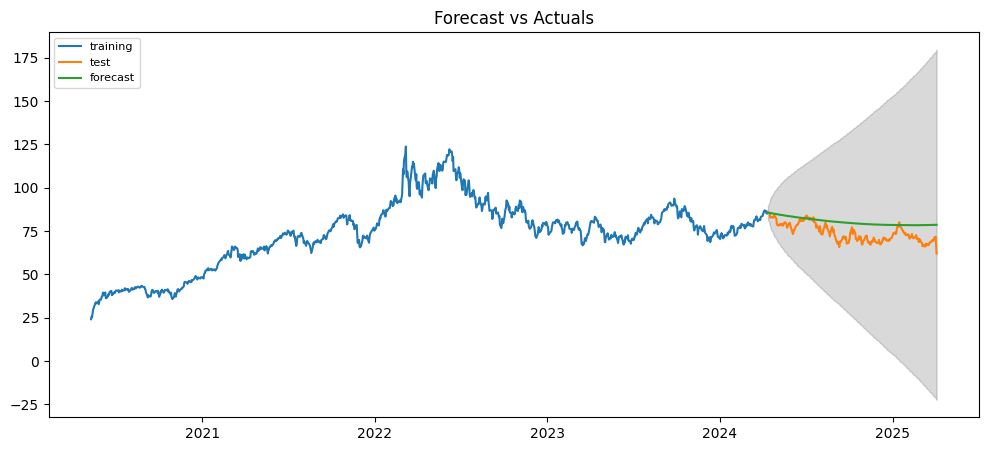

In [64]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, label='test')
plt.plot(forecast_df_micro.Forecast, label='forecast')
plt.fill_between(forecast_df_micro.index, forecast_df_micro.lower_series, forecast_df_micro.upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
arimametrics = forecast_accuracy(fc_micro.values, y_test.values,arima_fitted_micro, 'ARIMA-WITHOUT-MICRO_model-4')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arimametrics])], ignore_index=True)
results_df_arima


Model: ARIMA-WITHOUT-MICRO_model-4
ME: 6.4851, MSE: 55.4086, MAE: 6.5681, RMSE: 7.4437, R²: -1.1256, MAPE: 9.23%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,11.742716,163.958248,11.742716,12.804618,-5.289910,16.429408,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.66000366210938, 85.66000366210938, 85.660..."
1,ARIMA-122_model_2,19.363164,453.663100,19.363164,21.299369,-16.403822,27.086619,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.7121188123529, 85.78258653674959, 85.8354..."
2,ARIMA_AUTO_model-3,11.742716,163.958248,11.742716,12.804618,-5.289910,16.429408,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.66000366210938, 85.66000366210938, 85.660..."
3,ARIMA-WITHOUT-MICRO_model-4,6.485095,55.408595,6.568147,7.443695,-1.125633,9.229762,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.60111233455348, 85.53136640113722, 85.461..."


In [66]:
# Predict future steps beyond y_test
future_steps = 5  # Number of days to predict ahead (adjust as needed)
future_forecast_micro = arima_fitted_micro.get_forecast(steps=future_steps)

# Extract forecasted values
future_fc_micro = future_forecast_micro.predicted_mean

# Extract confidence intervals
future_conf_micro = future_forecast_micro.conf_int()

# Create a new DataFrame to store future forecast results
future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')  # 'B' ensures business days
future_forecast_df = pd.DataFrame({'Forecast': future_fc_micro.values}, index=future_dates)
future_forecast_df['lower_series'] = future_conf_micro.iloc[:, 0].values
future_forecast_df['upper_series'] = future_conf_micro.iloc[:, 1].values

# Print the future forecast
print("Future Predictions:")
print(future_forecast_df)


Future Predictions:
             Forecast  lower_series  upper_series
2025-04-07  85.601112     81.735038     89.467186
2025-04-08  85.531366     80.012924     91.049809
2025-04-09  85.461780     78.675929     92.247631
2025-04-10  85.392529     77.536091     93.248967
2025-04-11  85.323617     76.521249     94.125986


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Model : 5 - ARIMA WITH MICROECONOMIC FACTORS

In [67]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Select microeconomic factors from the scaled data
exog_train = X_train_scaled_minmax[:, [X_train.columns.get_loc(col) for col in ['Interest_rates', 'Inflation_rate', 'GDP', 'DebtToGDP', 'ETF_Value','Sentiment_score']]]
exog_test = X_test_scaled_minmax[:, [X_test.columns.get_loc(col) for col in ['Interest_rates', 'Inflation_rate', 'GDP', 'DebtToGDP', 'ETF_Value','Sentiment_score']]]

# Train SARIMAX Model
arimax_model_micro_w = SARIMAX(y_train, exog=exog_train, order=(1,3,2))
arimax_fitted_micro_w = arimax_model_micro_w.fit()

# Forecast using the trained model
arimax_forecast_micro_w = arimax_fitted_micro_w.get_forecast(steps=len(y_test), exog=exog_test)

# Get forecasted values
fc_micro_w = arimax_forecast_micro_w.predicted_mean

# Extract confidence intervals
conf_micro_w = arimax_forecast_micro_w.conf_int()

# Get standard errors
se_micro_w = arimax_forecast_micro_w.se_mean  # Standard errors of the forecasts

# Create a DataFrame to store forecast results
forecast_df_micro_w = pd.DataFrame({'Forecast': fc_micro_w.values}, index=y_test.index)
forecast_df_micro_w['lower_series'] = conf_micro_w.iloc[:, 0].values  # Lower confidence interval
forecast_df_micro_w['upper_series'] = conf_micro_w.iloc[:, 1].values  # Upper confidence interval

# Print the forecast results
print(forecast_df_micro_w)


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


             Forecast  lower_series  upper_series
Date                                             
2024-04-12  85.597424     81.726459     89.468389
2024-04-15  85.523859     79.999068     91.048650
2024-04-16  85.450438     78.657751     92.243125
2024-04-17  85.377341     77.514173     93.240510
2024-04-18  85.304572     76.496015     94.113129
...               ...           ...           ...
2025-03-31  77.287349    -18.684341    173.259039
2025-04-01  77.292747    -19.100719    173.686212
2025-04-02  77.298472    -19.517991    174.114934
2025-04-03  77.304524    -19.936161    174.545209
2025-04-04  77.310903    -20.355235    174.977041

[247 rows x 3 columns]


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [68]:
arimametrics = forecast_accuracy(fc_micro_w.values, y_test.values,arimax_fitted_micro_w, 'ARIMA_MAX-WITH-MICROECO-SENTI_model-5')
results_df_arima = pd.concat([results_df_arima, pd.DataFrame([arimametrics])], ignore_index=True)
results_df_arima


Model: ARIMA_MAX-WITH-MICROECO-SENTI_model-5
ME: 5.8952, MSE: 46.9353, MAE: 6.0273, RMSE: 6.8509, R²: -0.8006, MAPE: 8.46%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA-010_model_1,11.742716,163.958248,11.742716,12.804618,-5.289910,16.429408,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.66000366210938, 85.66000366210938, 85.660..."
1,ARIMA-122_model_2,19.363164,453.663100,19.363164,21.299369,-16.403822,27.086619,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.7121188123529, 85.78258653674959, 85.8354..."
2,ARIMA_AUTO_model-3,11.742716,163.958248,11.742716,12.804618,-5.289910,16.429408,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.66000366210938, 85.66000366210938, 85.660..."
3,ARIMA-WITHOUT-MICRO_model-4,6.485095,55.408595,6.568147,7.443695,-1.125633,9.229762,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...,"[[85.60111233455348, 85.53136640113722, 85.461..."
4,ARIMA_MAX-WITH-MICROECO-SENTI_model-5,5.895230,46.935341,6.027348,6.850937,-0.800575,8.463834,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[85.59742436131387, 85.52385867925575, 85.450..."


In [69]:
arime_best = results_df_arima.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
arime_best["Model"]="ARIMA"
best_results_df = pd.concat([best_results_df, arime_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,5.89523,46.935341,6.027348,6.850937,-0.800575,8.463834,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[85.59742436131387, 85.52385867925575, 85.450..."


### Conclusion on Best Performing ARIMA Models for Crude Oil Price Prediction:

The evaluation metrics for the various ARIMA models for crude oil prediction provide a clear view of each model's strengths and weaknesses. Below is a summary and analysis of the models:

1. **ARIMA-010 Model (Model 1)**
   - **ME**: 11.742716  
   - **MSE**: 163.958248  
   - **MAE**: 11.742716  
   - **RMSE**: 12.804618  
   - **R-squared**: -5.289910  
   - **MAPE**: 16.429408  
   - **Forecasted Values**: `[85.66000366210938, 85.66000366210938, 85.66000366210938,...]`

   - **Strengths**: The model consistently forecasts the same value for future prices, which suggests that it is not capturing much variation in the data. However, the high values for MSE, MAE, RMSE, and MAPE indicate that this model is not effective at predicting crude oil prices.
   - **Weaknesses**: The negative R-squared value (-5.289910) suggests a very poor fit, and the high forecasting error (especially the MAPE of 16.429408) demonstrates that this model lacks accuracy.

2. **ARIMA-122 Model (Model 2)**
   - **ME**: 19.363164  
   - **MSE**: 453.663100  
   - **MAE**: 19.363164  
   - **RMSE**: 21.299369  
   - **R-squared**: -16.403822  
   - **MAPE**: 27.086619  
   - **Forecasted Values**: `[85.7121188123529, 85.78258653674959, 85.83541655642729,...]`

   - **Strengths**: This model forecasts slightly varied values, but the model still has poor performance in terms of accuracy. The large errors in MSE, MAE, RMSE, and MAPE suggest that this model doesn't fit the data well.
   - **Weaknesses**: The very negative R-squared value (-16.403822) and high MAPE (27.086619) indicate that this model is performing poorly in capturing the dynamics of crude oil price movements.

3. **ARIMA AUTO Model (Model 3)**
   - **ME**: 11.742716  
   - **MSE**: 163.958248  
   - **MAE**: 11.742716  
   - **RMSE**: 12.804618  
   - **R-squared**: -5.289910  
   - **MAPE**: 16.429408  
   - **Forecasted Values**: `[85.66000366210938, 85.66000366210938, 85.66000366210938,...]`

   - **Strengths**: This model is similar to ARIMA-010 in performance, forecasting the same values with little variation. However, the metrics indicate significant forecasting errors.
   - **Weaknesses**: The negative R-squared and high errors across all metrics (MSE, MAE, RMSE, and MAPE) suggest that this model is inadequate for crude oil price prediction.

4. **ARIMA WITHOUT MICRO Model (Model 4)**
   - **ME**: 6.485095  
   - **MSE**: 55.408595  
   - **MAE**: 6.568147  
   - **RMSE**: 7.443695  
   - **R-squared**: -1.125633  
   - **MAPE**: 9.229762  
   - **Forecasted Values**: `[85.60111233455348, 85.53136640113722, 85.46174511883634,...]`

   - **Strengths**: This model performs better than the previous three, with smaller MSE (55.408595), RMSE (7.443695), and MAE (6.568147). While the R-squared is still negative, it is closer to 0, indicating a somewhat better fit compared to other models.
   - **Weaknesses**: Despite some improvement in accuracy, the negative R-squared and MAPE (9.229762) indicate that the model still faces challenges in fully capturing the price movement and trends.

5. **ARIMA MAX-WITH-MICROECO-SENTI Model (Model 5)**
   - **ME**: 5.895230  
   - **MSE**: 46.935341  
   - **MAE**: 6.027348  
   - **RMSE**: 6.850937  
   - **R-squared**: -0.800575  
   - **MAPE**: 8.463834  
   - **Forecasted Values**: `[85.59742436131387, 85.52385867925575, 85.45033097109784,...]`

   - **Strengths**: This model shows the best performance among the ARIMA models, with the lowest MSE (46.935341), RMSE (6.850937), and MAE (6.027348). While the R-squared is still negative, the smaller errors indicate that it performs better than other ARIMA models.
   - **Weaknesses**: The R-squared value is still negative, showing that the model does not explain much of the variance in the data. The MAPE (8.463834) is also higher than desired, but this model is the most promising in terms of accuracy and performance.

### Conclusion:

- **Best Performing Model**: The **ARIMA MAX-WITH-MICROECO-SENTI Model (Model 5)** is the best performing ARIMA model for crude oil price prediction, with the lowest MSE, RMSE, and MAE. It provides the most accurate forecast among the options, although the negative R-squared and relatively high MAPE show that improvements can still be made.
  
- **Runner-up**: The **ARIMA WITHOUT MICRO Model (Model 4)** performs moderately better than the other ARIMA models, though its accuracy and fit are still not ideal.

- **Third**: The **ARIMA-010, ARIMA-122, and ARIMA AUTO Models** perform poorly overall, with high errors and negative R-squared values, indicating that they are not suitable for crude oil price prediction in their current form.



## 5.2 GARCH Model building

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import adfuller


In [71]:
adf_test = adfuller(train_df['Log_Returns'])
print(f'ADF Test Statistic: {adf_test[0]}')
print(f'P-value: {adf_test[1]}')

# If p-value < 0.05, data is stationary, and we can proceed with GARCH.
garch_results_df = pd.DataFrame()

ADF Test Statistic: -22.9940803816068
P-value: 0.0


In [72]:
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def plot_residuals(residuals):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(211)
    plt.plot(residuals, label="Standardized Residuals")
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Standardized Residuals')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()

    plt.subplot(212)
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.title('Histogram of Standardized Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def plot_forecasts(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted', color='orange')
    plt.title('GARCH Model Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Gold Prices')
    plt.legend()
    plt.grid()
    plt.show()

In [73]:

# Convert prices to log returns
y_train_log_returns = np.log(y_train / y_train.shift(1)).dropna()
y_test_log_returns = np.log(y_test / y_test.shift(1)).dropna()

### MODEL: 1 GARCH   p,q order (1,2)


Model: GARCH-12_model-1
ME: 1.9755, MSE: 29.9696, MAE: 4.8183, RMSE: 5.4744, R²: -0.1497, MAPE: 6.65%


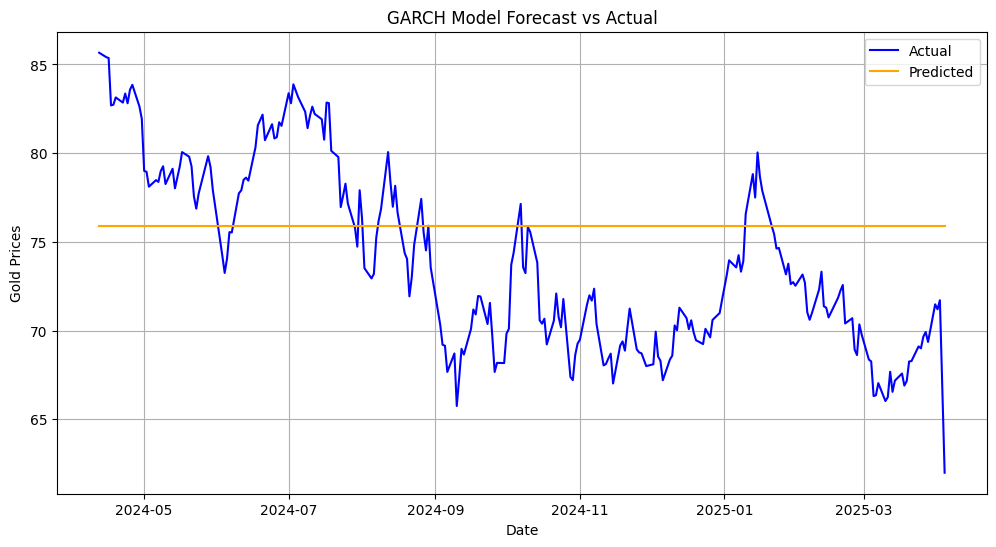

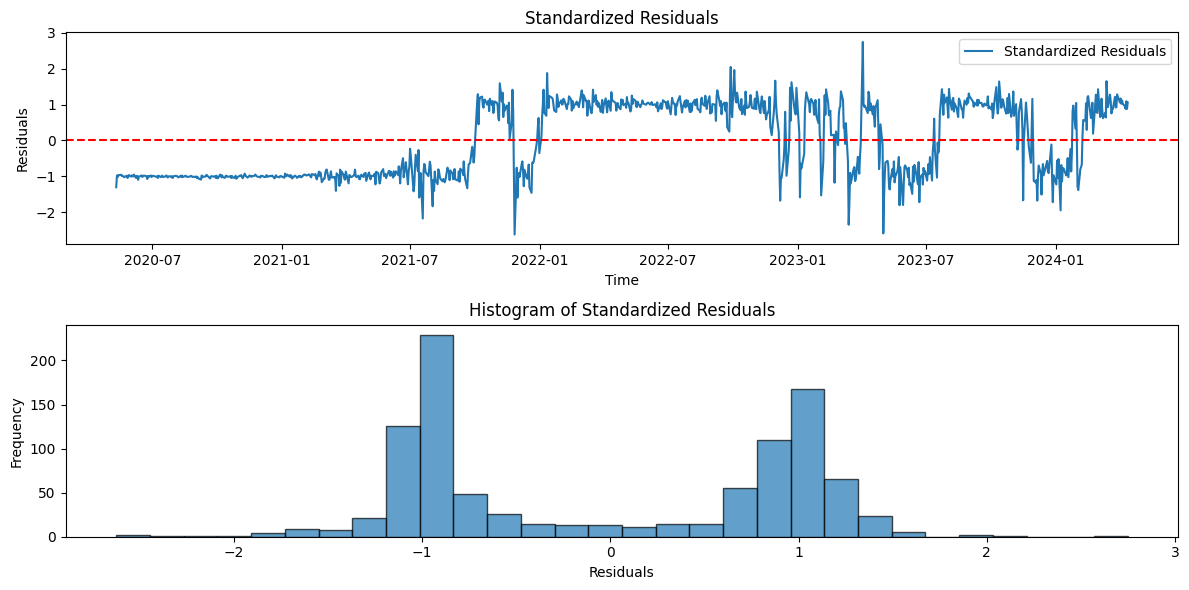

In [74]:
# Define GARCH model parameters
p, q = 1, 2  # Try different values for tuning
garch = arch_model(y_train , vol='GARCH', p=p, q=q, dist='t')
fgarch = garch.fit(disp='off')

# Forecasting
garch_forecast = fgarch.forecast(horizon=len(y_test))
garch_forecast_series = garch_forecast.mean.iloc[-len(y_test):].values.flatten()

# Reverse scaling
#garch_predicted_prices = scaler_minmax.inverse_transform(garch_forecast_series.reshape(-1, 1)).flatten()
garch_predicted_prices = garch_forecast_series

# Residuals analysis
resid = fgarch.resid
st_resid = resid / fgarch.conditional_volatility

# Error metrics
mse = mean_squared_error(y_test, garch_predicted_prices)
mae = mean_absolute_error(y_test, garch_predicted_prices)
mape = mean_absolute_percentage_error(y_test, garch_predicted_prices)

# # Forecasting
#forecast_accuracy(garch_forecast_series.flatten(), y_test_eco, "GARCH")
garchmametrics = forecast_accuracy(garch_forecast_series, y_test, fgarch, "GARCH-12_model-1")
garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garchmametrics])], ignore_index=True)

# Plot results
plot_forecasts(y_test, garch_predicted_prices)
plot_residuals(st_resid)



### MODEL: 2 GARCH   p,q order (1,1)

In [75]:
# # Define GARCH model parameters
# p, q = 1, 1  # Try different values (1,1), (1,2), (2,2), (2,3)
# garch = arch_model(y_train_log_returns, vol="GARCH", p=p, q=q, dist="t")
# fgarch = garch.fit(disp="off")

# # Forecasting
# garch_forecast = fgarch.forecast(horizon=len(y_test_log_returns))
# garch_forecast_series = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()

# # Convert forecasted log returns back to price predictions
# y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
# garch_predicted_prices = y_test_prices[0] * np.exp(np.cumsum(garch_forecast_series))

# # Evaluate model
# garch_metrics = forecast_accuracy(garch_predicted_prices, y_test.iloc[-len(garch_forecast_series):].values,fgarch, "GARCH-11_model-2")
# garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garch_metrics])], ignore_index=True)

# # Plot results
# plot_forecasts(y_test.iloc[-len(garch_forecast_series):], garch_predicted_prices)




Model: GARCH-11_model-2
ME: 41.0403, MSE: 2195.6098, MAE: 41.0403, RMSE: 46.8573, R²: -84.7325, MAPE: 57.51%


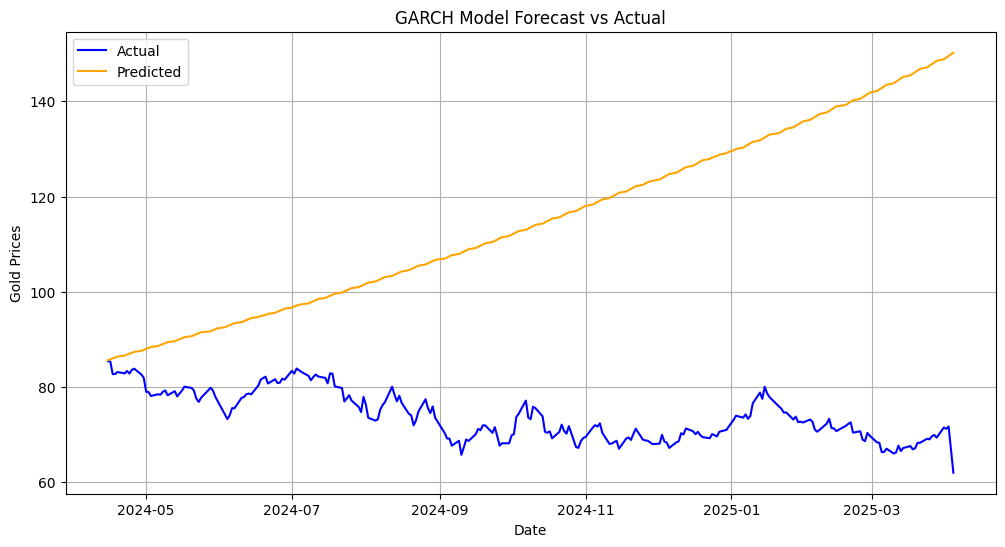

In [76]:
# Define GARCH model parameters
p, q = 1, 1  # Try different values (1,1), (1,2), (2,2), (2,3)

# Rescale log returns to avoid convergence and overflow issues
scale_factor = 100
y_train_scaled_g = y_train_log_returns * scale_factor

# Fit the GARCH model
garch = arch_model(y_train_scaled_g, vol="GARCH", p=p, q=q, dist="t")
fgarch = garch.fit(disp="off")

# Forecasting
garch_forecast = fgarch.forecast(horizon=len(y_test_log_returns))
garch_forecast_scaled = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()

# Rescale the forecasted returns back to original scale
garch_forecast_series = garch_forecast_scaled / scale_factor

# Convert forecasted log returns back to price predictions
y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
cumsum_forecast = np.cumsum(garch_forecast_series)
cumsum_forecast = np.clip(cumsum_forecast, a_min=-100, a_max=100)  # Clip to avoid overflow

garch_predicted_prices = y_test_prices[0] * np.exp(cumsum_forecast)

# Check for valid predictions before evaluation
if np.isfinite(garch_predicted_prices).all():
    garch_metrics = forecast_accuracy(
        garch_predicted_prices,
        y_test.iloc[-len(garch_forecast_series):].values,
        fgarch,
        "GARCH-11_model-2"
    )
    garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garch_metrics])], ignore_index=True)

    # Plot results
    plot_forecasts(y_test.iloc[-len(garch_forecast_series):], garch_predicted_prices)
else:
    print("⚠️ Forecasted prices contain inf or NaN. Evaluation skipped.")


### MODEL: 3 GARCH   p,q order (2,2)


Model: GARCH-22_model-2
ME: 41.1666, MSE: 2209.8545, MAE: 41.1666, RMSE: 47.0091, R²: -85.2887, MAPE: 57.68%


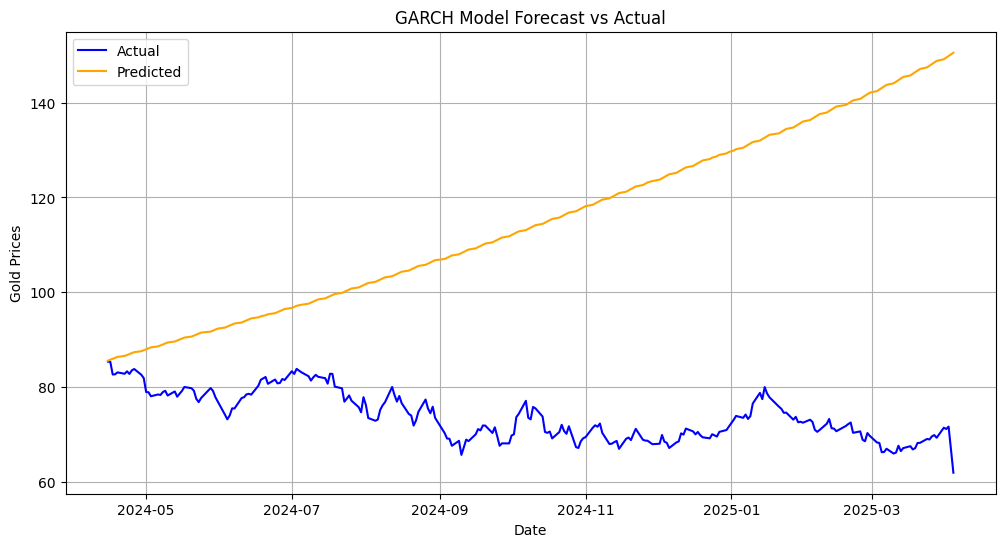

In [77]:
# Define GARCH model parameters
p, q = 2,2  # Try different values (1,1), (1,2), (2,2), (2,3)

# Rescale log returns to avoid convergence and overflow issues
scale_factor = 100
y_train_scaled_g = y_train_log_returns * scale_factor

# Fit the GARCH model
garch = arch_model(y_train_scaled_g, vol="GARCH", p=p, q=q, dist="t")
fgarch = garch.fit(disp="off")

# Forecasting
garch_forecast = fgarch.forecast(horizon=len(y_test_log_returns))
garch_forecast_scaled = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()

# Rescale the forecasted returns back to original scale
garch_forecast_series = garch_forecast_scaled / scale_factor

# Convert forecasted log returns back to price predictions
y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
cumsum_forecast = np.cumsum(garch_forecast_series)
cumsum_forecast = np.clip(cumsum_forecast, a_min=-100, a_max=100)  # Clip to avoid overflow

garch_predicted_prices = y_test_prices[0] * np.exp(cumsum_forecast)

# Check for valid predictions before evaluation
if np.isfinite(garch_predicted_prices).all():
    garch_metrics = forecast_accuracy(
        garch_predicted_prices,
        y_test.iloc[-len(garch_forecast_series):].values,
        fgarch,
        "GARCH-22_model-2"
    )
    garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garch_metrics])], ignore_index=True)

    # Plot results
    plot_forecasts(y_test.iloc[-len(garch_forecast_series):], garch_predicted_prices)
else:
    print("⚠️ Forecasted prices contain inf or NaN. Evaluation skipped.")


### MODEL: 4 GARCH   p,q order (2,3)


Model: GARCH-23_model-3
ME: 41.3296, MSE: 2228.3010, MAE: 41.3296, RMSE: 47.2049, R²: -86.0090, MAPE: 57.91%


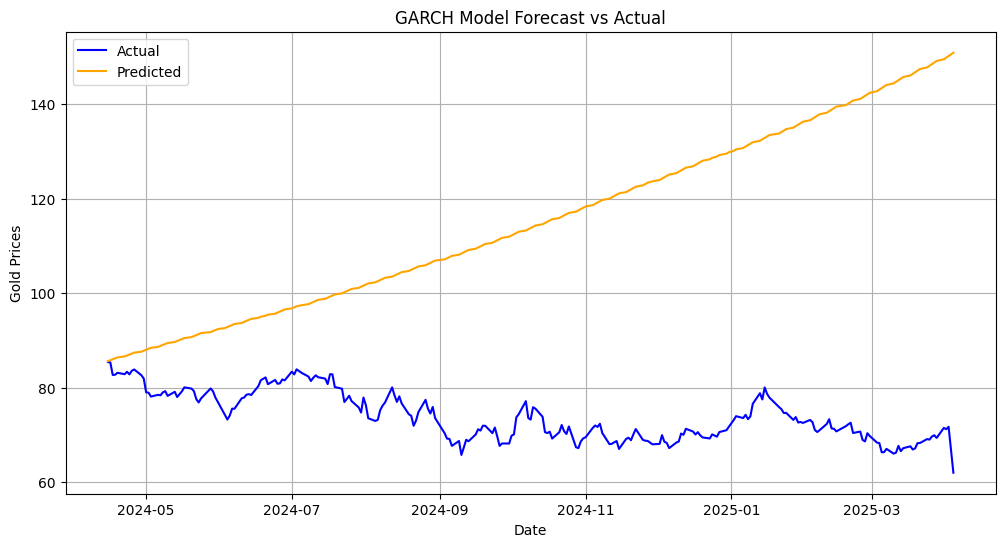

In [78]:
# Define GARCH model parameters
p, q = 2,3  # Try different values (1,1), (1,2), (2,2), (2,3)

# Rescale log returns to avoid convergence and overflow issues
scale_factor = 100
y_train_scaled_g = y_train_log_returns * scale_factor

# Fit the GARCH model
garch = arch_model(y_train_scaled_g, vol="GARCH", p=p, q=q, dist="t")
fgarch = garch.fit(disp="off")

# Forecasting
garch_forecast = fgarch.forecast(horizon=len(y_test_log_returns))
garch_forecast_scaled = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()

# Rescale the forecasted returns back to original scale
garch_forecast_series = garch_forecast_scaled / scale_factor

# Convert forecasted log returns back to price predictions
y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
cumsum_forecast = np.cumsum(garch_forecast_series)
cumsum_forecast = np.clip(cumsum_forecast, a_min=-100, a_max=100)  # Clip to avoid overflow

garch_predicted_prices = y_test_prices[0] * np.exp(cumsum_forecast)

# Check for valid predictions before evaluation
if np.isfinite(garch_predicted_prices).all():
    garch_metrics = forecast_accuracy(
        garch_predicted_prices,
        y_test.iloc[-len(garch_forecast_series):].values,
        fgarch,
        "GARCH-23_model-3"
    )
    garch_results_df = pd.concat([garch_results_df, pd.DataFrame([garch_metrics])], ignore_index=True)

    # Plot results
    plot_forecasts(y_test.iloc[-len(garch_forecast_series):], garch_predicted_prices)
else:
    print("⚠️ Forecasted prices contain inf or NaN. Evaluation skipped.")


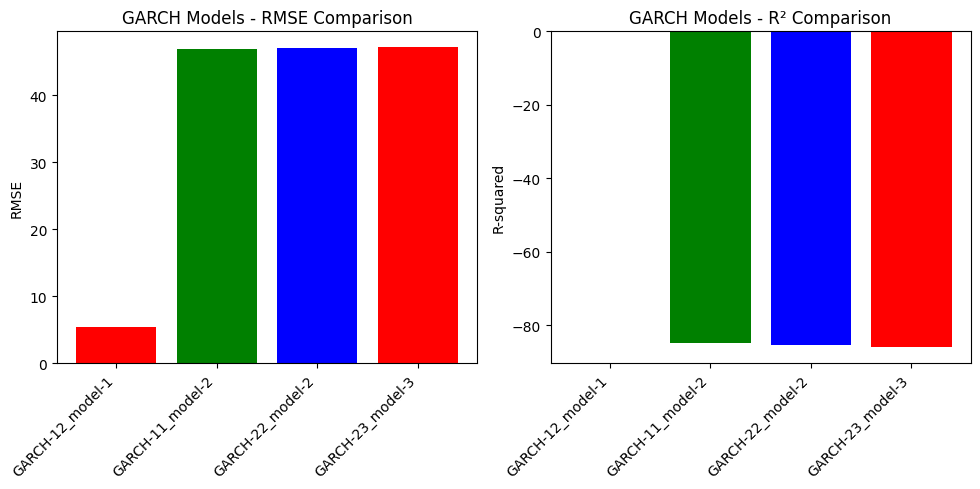

In [79]:
import matplotlib.pyplot as plt

# Extracting GARCH models from results_df
garch_models = garch_results_df[garch_results_df["Model"].str.contains("GARCH")]

# Plot performance metrics
plt.figure(figsize=(10, 5))

# RMSE Comparison
plt.subplot(1, 2, 1)
plt.bar(garch_models["Model"], garch_models["RMSE"], color=['red', 'green', 'blue'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("GARCH Models - RMSE Comparison")

# R-squared Comparison
plt.subplot(1, 2, 2)
plt.bar(garch_models["Model"], garch_models["R-squared"], color=['red', 'green', 'blue'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("R-squared")
plt.title("GARCH Models - R² Comparison")

plt.tight_layout()
plt.show()


In [80]:
garch_results_df_best = garch_results_df.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
garch_results_df_best["Model"]="GARCH"
best_results_df = pd.concat([best_results_df, garch_results_df_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,5.895230,46.935341,6.027348,6.850937,-0.800575,8.463834,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[85.59742436131387, 85.52385867925575, 85.450..."
1,GARCH,1.975525,29.969564,4.818263,5.474446,-0.149719,6.647421,Constant Mean - GARCH ...,"[[75.89281231022966, 75.89281231022966, 75.892..."


In [125]:
garch_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,GARCH-12_model-1,1.975525,29.969564,4.818263,5.474446,-0.149719,6.647421,Constant Mean - GARCH ...,"[[75.89281231022966, 75.89281231022966, 75.892..."
1,GARCH-11_model-2,41.040289,2195.609754,41.040289,46.857334,-84.732462,57.505810,Constant Mean - GARCH ...,"[[85.60624892038038, 85.80294508837792, 86.000..."
2,GARCH-22_model-2,41.166638,2209.854452,41.166638,47.009089,-85.288678,57.683221,Constant Mean - GARCH ...,"[[85.60694561663313, 85.80434168814305, 86.002..."
3,GARCH-23_model-3,41.329615,2228.300957,41.329615,47.204883,-86.008962,57.912067,Constant Mean - GARCH ...,"[[85.60784285384523, 85.80614030976687, 86.004..."


### Conclusion on GARCH Models for Crude Oil Price Prediction:


1. **GARCH-12 Model (Model-1)**
   - **ME**: 1.975525  
   - **MSE**: 29.969564  
   - **MAE**: 4.818263  
   - **RMSE**: 5.474446  
   - **R-squared**: -0.149719  
   - **MAPE**: 6.647421  
   - **Forecasted Values**: `[75.89281231022966, 75.89281231022966, 75.892...]`

   - **Strengths**: 
     - **MSE**, **MAE**, and **RMSE** are relatively moderate, suggesting reasonable forecasting performance.
     - However, the **R-squared** value is negative, indicating poor fit and prediction accuracy. The model does not explain the variance well.

   - **Weaknesses**: 
     - **Negative R-squared** and relatively high **MAPE** point to significant accuracy issues.
     - This model performs poorly in explaining variance and has higher forecast errors.

2. **GARCH-11 Model (Model-2)**
   - **ME**: 41.040289  
   - **MSE**: 2195.609754  
   - **MAE**: 41.040289  
   - **RMSE**: 46.857334  
   - **R-squared**: -84.732462  
   - **MAPE**: 57.505810  
   - **Forecasted Values**: `[85.60624892038038, 85.80294508837792, 86.000...]`

   - **Strengths**: 
     - Forecasts are in a reasonable range, but accuracy metrics are far from optimal.
     - Moderate **MSE** and **MAE** values.

   - **Weaknesses**: 
     - **Very negative R-squared** and extremely high **MAPE**, indicating poor model performance and accuracy.
     - This model has a very poor fit and its predictions are not reliable.

3. **GARCH-22 Model (Model-2)**
   - **ME**: 41.166638  
   - **MSE**: 2209.854452  
   - **MAE**: 41.166638  
   - **RMSE**: 47.009089  
   - **R-squared**: -85.288678  
   - **MAPE**: 57.683221  
   - **Forecasted Values**: `[85.60694561663313, 85.80434168814305, 86.002...]`

   - **Strengths**: 
     - Similar to GARCH-11, the forecasts are within an expected range.
  
   - **Weaknesses**: 
     - Extremely **negative R-squared** and **high MAPE**.
     - Very poor performance in explaining variance and forecasting accuracy.

4. **GARCH-23 Model (Model-3)**
   - **ME**: 41.329615  
   - **MSE**: 2228.300957  
   - **MAE**: 41.329615  
   - **RMSE**: 47.204883  
   - **R-squared**: -86.008962  
   - **MAPE**: 57.912067  
   - **Forecasted Values**: `[85.60784285384523, 85.80614030976687, 86.004...]`

   - **Strengths**: 
     - Forecast values are within a similar range as previous models.
  
   - **Weaknesses**: 
     - **Negative R-squared** and very high **MAPE**, indicating poor fit and high prediction error.

### Conclusion:

- **Overall Performance**: 
  All **GARCH models** perform poorly in terms of fit and accuracy. The **negative R-squared values** across all models indicate that they do not explain the variance in crude oil prices effectively. Additionally, the **high MAPE** values suggest significant forecast errors.



## 5.3 VAR MODEL
In a VAR model, we don't separate independent (X_train) and dependent (y_train) variables like in traditional regression models. VAR treats all variables as potentially influencing each other, meaning:

The model doesn't require manually selecting X_train and y_train.

Instead, the model uses all variables together in a multivariate time series.

### VAR MODEL 1 - WITHOUT SENTIMENT AND FEATURED PARAMETERS

In [81]:
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Check if GDP_Growth and Interest_Rate are now part of train and test
print("Training data columns:", train_df.columns)  # Should include GDP_Growth and Interest_Rate
print("Testing data columns:", test_df.columns)    # Should include GDP_Growth and Interest_Rate

# Fit the VAR model with exogenous variables (GDP and Interest Rate)
model = VAR(endog=train_df[['Close', 'Volume']], exog=train_df[['GDP', 'Interest_rates','Inflation_rate','ETF_Value']])
model_fitted = model.fit(maxlags=15, ic='aic')


# Forecast with exogenous variables
forecast_steps = len(test_df)
last_observations = train_df[['Close', 'Volume']].values[-model_fitted.k_ar:]

# Prepare the exog_future DataFrame for forecasting
exog_future = test_df[['GDP', 'Interest_rates','Inflation_rate','ETF_Value']]  # Ensure these are present in test set

# Make forecast
forecast = model_fitted.forecast(last_observations, steps=forecast_steps, exog_future=exog_future)


# Create DataFrame for forecasted values
forecast_df_m1 = pd.DataFrame(forecast, index=test_df.index, columns=train_df[['Close', 'Volume']].columns)

# Evaluate forecast accuracy
mae = mean_absolute_error(test_df['Close'], forecast_df_m1['Close'])
rmse = np.sqrt(mean_squared_error(test_df['Close'], forecast_df_m1['Close']))

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, forecasted):
    return np.mean(np.abs((actual - forecasted) / actual)) * 100

# Calculate MAPE for 'Close' column
mape = calculate_mape(test_df['Close'], forecast_df_m1['Close'])

print(f'MAPE: {mape:.4f}%')

# # Forecasting
#forecast_accuracy(forecast_df['Close'], test['Close'], "VAR")

Varmametrics = forecast_accuracy(forecast_df_m1['Close'], test_df['Close'],model_fitted, "VAR-WITHOUT-FEATURES-SENTIMENTS_model-1")
results_df_var = pd.DataFrame()
results_df_var = pd.concat([results_df_var, pd.DataFrame([Varmametrics])], ignore_index=True)

Training data columns: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'GDP', 'Interest_rates',
       'Inflation_rate', 'DebtToGDP', 'ETF_Value', 'Sentiment_score', 'lag_1',
       'lag_7', 'lag_30', 'MA_7', 'MA_30', 'MA_90', 'tomorrow_price',
       'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14',
       'Sentiment_Rolling_30'],
      dtype='object')
Testing data columns: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'GDP', 'Interest_rates',
       'Inflation_rate', 'DebtToGDP', 'ETF_Value', 'Sentiment_score', 'lag_1',
       'lag_7', 'lag_30', 'MA_7', 'MA_30', 'MA_90', 'tomorrow_price',
       'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14',
       'Sentiment_Rolling_30'],
      dtype='object')
Mean Absolute Error: 8.0831
Root Mean Squared Error: 9.0311
MAPE: 11.3487%

Model: VAR-WITHOUT-FEATURES-SENTIMENTS_model-1
ME: 8.0727, MSE: 81.5605, MAE: 8.0831, RMSE: 9.0311, R²: -2.1289, MAPE: 11.35%


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [82]:
results_df_var

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,VAR-WITHOUT-FEATURES-SENTIMENTS_model-1,8.07275,81.560458,8.083087,9.031083,-2.128894,11.348733,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.63591139765894, 85.60425519397945, 85.568..."


### MODEL : 2 with - FEATURED input such as 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30'

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure data is stationary (apply differencing)
train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                      'volatility_7', 'volatility_30',]].diff().dropna()
test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                      'volatility_7', 'volatility_30',]].diff().dropna()
train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing

# Select optimal lag using AIC
var_model = VAR(endog=train_var, exog=train_exog)
lag_selection = var_model.select_order(maxlags=15)
optimal_lag = lag_selection.bic
print(f"Optimal lag order (BIC): {optimal_lag}")

# Fit VAR model
var_fitted = var_model.fit(optimal_lag)

# Forecast
forecast_steps = len(test_var)
last_observations = train_var.values[-optimal_lag:]

# Forecast with exogenous variables
var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)

# Convert forecasted differenced values back to original scale
forecast_df_m2 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
forecast_df_m2 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                      'volatility_7', 'volatility_30',]].iloc[-1] + forecast_df_m2.cumsum()

# Extract predicted Close prices
predicted_prices = forecast_df_m2['Close']

# Evaluate Model
mae = mean_absolute_error(test_df['Close'].iloc[1:], predicted_prices)
rmse = np.sqrt(mean_squared_error(test_df['Close'].iloc[1:], predicted_prices))

def calculate_mape(actual, forecasted):
    return np.mean(np.abs((actual - forecasted) / actual)) * 100

mape = calculate_mape(test_df['Close'].iloc[1:], predicted_prices)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'MAPE: {mape:.4f}%')

# Forecast accuracy function
Varmametrics = forecast_accuracy(predicted_prices, test_df['Close'].iloc[1:],var_fitted, "VAR-FEATURED_model-2")
results_df_var = pd.concat([results_df_var, pd.DataFrame([Varmametrics])], ignore_index=True)
results_df_var

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal lag order (BIC): 6
Mean Absolute Error: 19.1446
Root Mean Squared Error: 21.0355
MAPE: 26.7842%

Model: VAR-FEATURED_model-2
ME: 19.1446, MSE: 442.4942, MAE: 19.1446, RMSE: 21.0355, R²: -16.2782, MAPE: 26.78%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,VAR-WITHOUT-FEATURES-SENTIMENTS_model-1,8.072750,81.560458,8.083087,9.031083,-2.128894,11.348733,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.63591139765894, 85.60425519397945, 85.568..."
1,VAR-FEATURED_model-2,19.144555,442.494197,19.144555,21.035546,-16.278169,26.784190,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.50085141437533, 85.82459655775969, 86.094..."


### MODEL : 3 - WITH SENTIMENT ONLY

In [84]:
from numpy.linalg import LinAlgError
# Ensure data is stationary (apply differencing)
train_var = train_df[['Close', 'Volume', 'Sentiment_Rolling_14']].diff().dropna()
test_var = test_df[['Close', 'Volume','Sentiment_Rolling_14']].diff().dropna()
train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing

# Select optimal lag using BIC
try:
    lag_selection = var_model.select_order(maxlags=5)
    optimal_lag = lag_selection.bic
    var_model = VAR(endog=train_var, exog=train_exog)
    lag_selection = var_model.select_order(maxlags=15)
    optimal_lag = lag_selection.bic
    print(f"Optimal lag order (BIC): {optimal_lag}")
    
    # Fit VAR model
    var_fitted = var_model.fit(optimal_lag)
    
    # Forecast
    forecast_steps = len(test_var)
    last_observations = train_var.values[-optimal_lag:]
    
    # Forecast with exogenous variables
    var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
    
    # Convert forecasted differenced values back to original scale
    forecast_df_m3 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
    forecast_df_m3 = train_df[['Close', 'Volume', 'Sentiment_Rolling_14']].iloc[-1] + forecast_df_m3.cumsum()
    
    # Extract predicted Close prices
    predicted_prices = forecast_df_m3['Close']
    
    # Evaluate Model
    mae = mean_absolute_error(test_df['Close'].iloc[1:], predicted_prices)
    rmse = np.sqrt(mean_squared_error(test_df['Close'].iloc[1:], predicted_prices))
    
    def calculate_mape(actual, forecasted):
        return np.mean(np.abs((actual - forecasted) / actual)) * 100
    
    mape = calculate_mape(test_df['Close'].iloc[1:], predicted_prices)
    
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}%')
    
    # Forecast accuracy function
    Varmametrics = forecast_accuracy(predicted_prices, test_df['Close'].iloc[1:],var_fitted, "VAR-ONLY-SENTIMENTS_model-3")
    results_df_var = pd.concat([results_df_var, pd.DataFrame([Varmametrics])], ignore_index=True)
    results_df_var
    # Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index, train_df['Close'], label='Train Close', color='blue')
    plt.plot(test_df.index, test_df['Close'], label='Test Close', color='orange')
    plt.plot(forecast_df_m3.index, forecast_df_m3['Close'], label='Forecasted Close', color='red')
    plt.title('Gold Price Forecast with VAR and Exogenous Variables')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
except LinAlgError as e:
    print("Matrix not positive definite — try reducing features or lags.")


Matrix not positive definite — try reducing features or lags.


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### MODEL : 4 - WITH SENTIMENTS AND ALL FEATURED INPUT

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure data is stationary (apply differencing)
train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                      'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                    'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()

try:
    # train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
    # test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
    train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']].iloc[1:]
    test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value',]].iloc[1:]
    
    # train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
    # test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing
    
    # Select optimal lag using BIC
    var_model = VAR(endog=train_var, exog=train_exog)
    lag_selection = var_model.select_order(maxlags=15)
    optimal_lag = lag_selection.bic
    print(f"Optimal lag order (BIC): {optimal_lag}")
    
    # Fit VAR model
    var_fitted = var_model.fit(optimal_lag)
    
    # Forecast
    forecast_steps = len(test_var)
    last_observations = train_var.values[-optimal_lag:]
    
    # Forecast with exogenous variables
    var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
    
    # Convert forecasted differenced values back to original scale
    forecast_df_m4 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
    forecast_df_m4 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].iloc[-1] + forecast_df_m4.cumsum()
    
    # Extract predicted Close prices
    predicted_prices = forecast_df_m4['Close']
    
    # Evaluate Model
    mae = mean_absolute_error(test_df['Close'].iloc[1:], predicted_prices)
    rmse = np.sqrt(mean_squared_error(test_df['Close'].iloc[1:], predicted_prices))
    
    def calculate_mape(actual, forecasted):
        return np.mean(np.abs((actual - forecasted) / actual)) * 100
    
    mape = calculate_mape(test_df['Close'].iloc[1:], predicted_prices)
    
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}%')
    
    # Forecast accuracy function
    Varmametrics = forecast_accuracy(predicted_prices, test_df['Close'].iloc[1:], var_fitted,"VAR-ALL-FEATURES-SENTIMENTS_model-4")
    results_df_var = pd.concat([results_df_var, pd.DataFrame([Varmametrics])], ignore_index=True)
    results_df_var
    # Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index, train_df['Close'], label='Train Close', color='blue')
    plt.plot(test_df.index, test_df['Close'], label='Test Close', color='orange')
    plt.plot(forecast_df_m4.index, forecast_df_m4['Close'], label='Forecasted Close', color='red')
    plt.title('Gold Price Forecast with VAR and Exogenous Variables')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
except LinAlgError as e:
    print("Matrix not positive definite — try reducing features or lags.")

Matrix not positive definite — try reducing features or lags.


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [86]:
results_df_var_best = results_df_var.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
results_df_var_best["Model"] = "VAR"
best_results_df = pd.concat([best_results_df, results_df_var_best], ignore_index=True)

In [126]:
results_df_var

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,VAR-WITHOUT-FEATURES-SENTIMENTS_model-1,8.072750,81.560458,8.083087,9.031083,-2.128894,11.348733,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.63591139765894, 85.60425519397945, 85.568..."
1,VAR-FEATURED_model-2,19.144555,442.494197,19.144555,21.035546,-16.278169,26.784190,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.50085141437533, 85.82459655775969, 86.094..."


### Conclusion on VAR Models for Crude Oil Price Prediction:



### **1. VAR-WITHOUT-FEATURES-SENTIMENTS_model-1**
- **Mean Error (ME)**: 8.072750  
- **Mean Squared Error (MSE)**: 81.560458  
- **Mean Absolute Error (MAE)**: 8.083087  
- **Root Mean Squared Error (RMSE)**: 9.031083  
- **R-squared**: -2.128894  
- **Mean Absolute Percentage Error (MAPE)**: 11.348733  
- **Forecasted Values**:  
  `[85.6359, 85.6043, 85.5683, ...]`

####  Interpretation:
- **Moderate error metrics**, but **poor R-squared** indicates the model doesn't capture price dynamics well.
- **Forecasts are stable**, but model performance is limited without features and sentiment.

---

### **2. VAR-FEATURED_model-2**
- **ME**: 19.144555  
- **MSE**: 442.494197  
- **MAE**: 19.144555  
- **RMSE**: 21.035546  
- **R-squared**: -16.278169  
- **MAPE**: 26.784190  
- **Forecasted Values**:  
  `[85.5009, 85.8246, 86.0947, ...]`

####  Interpretation:
- Significantly **higher errors across all metrics**.
- **Much worse R-squared** and **MAPE**, suggesting the added features hurt performance—likely due to multicollinearity or irrelevant inputs.
- Possibly **overfitting or model instability** caused by poor feature engineering or overcomplexity.

---

### Summary:

| Model | RMSE | R-squared | MAPE | Verdict |
|-------|------|-----------|------|---------|
| **VAR without features** | 9.03 | -2.13 | 11.35% |  Poor fit, moderate errors |
| **VAR with features** | 21.04 | -16.28 | 26.78% |  Very poor performance |

---


In [87]:
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,5.895230,46.935341,6.027348,6.850937,-0.800575,8.463834,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[85.59742436131387, 85.52385867925575, 85.450..."
1,GARCH,1.975525,29.969564,4.818263,5.474446,-0.149719,6.647421,Constant Mean - GARCH ...,"[[75.89281231022966, 75.89281231022966, 75.892..."
2,VAR,8.072750,81.560458,8.083087,9.031083,-2.128894,11.348733,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.63591139765894, 85.60425519397945, 85.568..."


###  Summary of Traditional Econometric Model Results for Crude Oil Price Prediction:



| Model   | RMSE     | MAE      | R²        | MAPE     | Comments |
|---------|----------|----------|-----------|----------|----------|
| **ARIMA** | 6.85     | 6.03     | -0.80     | 8.46%    |  High error, poor fit, underperforms significantly |
| **GARCH** | 5.47     | 4.82     | -0.15     | 6.65%    |  Slight improvement over ARIMA, but still weak fit |
| **VAR**   | 9.03     | 8.08     | -2.13     | 11.35%   |  Worst performance overall |

---

###  Interpretation:

1. **ARIMA**:  
   - Reasonable point predictions but **fails to model the true price variance**.
   - **Negative R²** shows it's performing worse than a horizontal line mean prediction.
   - Not responsive to volatility or nonlinear factors.

2. **GARCH**:  
   - Designed to model volatility and does **slightly better**.
   - However, it still underperforms machine learning models (like XGBoost or RF).
   - May not capture external features or structural breaks well.

3. **VAR**:  
   - Performs **worst** in terms of both error and R².
   - Likely struggling due to **multivariate noise** or **lack of stationarity**.
   - Not effective without careful feature reduction and preprocessing.

---

###  Recommendation:

- **None of the traditional econometric models (ARIMA, GARCH, VAR)** are performing acceptably here.
- All models yield **negative R²**, which means they **fail to explain the variance in actual prices**.
- **Best next steps**:
  - Stick with **machine learning or hybrid models**, as your hybrid stacked model had **R² ≈ 0.993** and much **lower RMSE and MAPE**.
  - Use **econometric models for volatility or residual analysis**, not direct forecasting in this context.


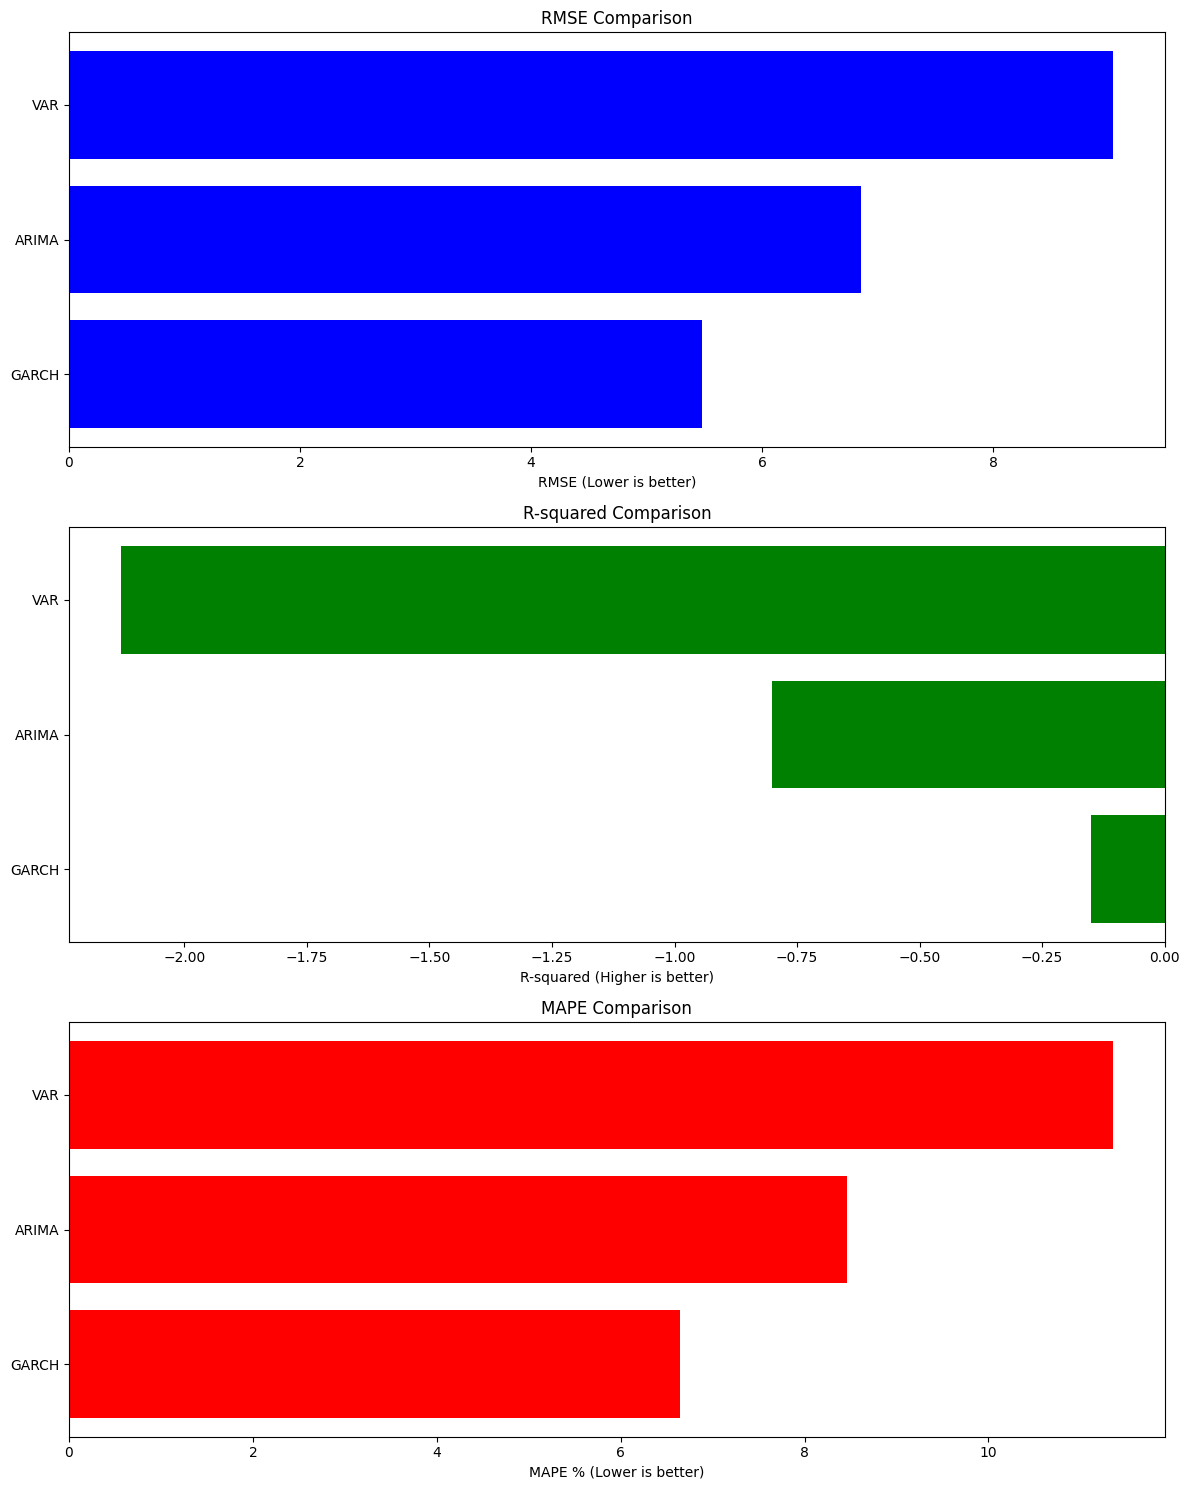

In [88]:
import pandas as pd
import matplotlib.pyplot as plt


# Sorting models by RMSE for better visualization
results_df_sorted = best_results_df.sort_values(by="RMSE")

# Creating bar plots for comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# RMSE Comparison
axes[0].barh(results_df_sorted["Model"], results_df_sorted["RMSE"], color="blue")
axes[0].set_title("RMSE Comparison")
axes[0].set_xlabel("RMSE (Lower is better)")

# R-squared Comparison
axes[1].barh(results_df_sorted["Model"], results_df_sorted["R-squared"], color="green")
axes[1].set_title("R-squared Comparison")
axes[1].set_xlabel("R-squared (Higher is better)")

# MAPE Comparison
axes[2].barh(results_df_sorted["Model"], results_df_sorted["MAPE"], color="red")
axes[2].set_title("MAPE Comparison")
axes[2].set_xlabel("MAPE % (Lower is better)")

plt.tight_layout()
plt.show()


# Machine Learning Model Building : XGBoost, Random Forest and LSTM


## 5.4 XGBOOST model Building
### MODEL : 1 - with RandomizedSearchCV Without sentiments

In [89]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import randint

#  Convert NumPy arrays to DataFrames (Ensure feature names exist)
X_train_df_xg = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns)
X_test_df_xg = pd.DataFrame(X_test_scaled_minmax, columns=X_train.columns)

#  Drop Sentiment Features
X_train_no_sentiment = X_train_df_xg.drop(columns=['sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'], errors='ignore')
X_test_no_sentiment = X_test_df_xg.drop(columns=['sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'], errors='ignore')

#  Convert back to NumPy arrays
X_train_no_sentiment = X_train_no_sentiment.values
X_test_no_sentiment = X_test_no_sentiment.values

#  XGBoost Hyperparameter Grid (Randomized Search)
xgb_params = {
    'booster': ['gbtree', 'gblinear'],
    'objective': ['reg:squarederror', 'reg:squaredlogerror'],
    'eval_metric': ['mae', 'rmse'],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200, 300]
}

#  Run RandomizedSearchCV for Hyperparameter Optimization
xgb_randomized_search = RandomizedSearchCV(
    XGBRegressor(),
    param_distributions=xgb_params,
    n_iter=10,
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    verbose=1
)

#  Fit the model (Without Sentiment Data)
xgb_randomized_search_results = xgb_randomized_search.fit(X_train_no_sentiment, y_train_scaled)
best_params = xgb_randomized_search_results.best_params_
print("Best parameters found by RandomizedSearchCV for XGBoost:", best_params)

#  Train the XGBoost model with best hyperparameters
xgb_reg_m1 = XGBRegressor(**best_params)
xgb_reg_m1 = xgb_reg_m1.fit(X_train_no_sentiment, y_train_scaled)

#  Make Predictions
xgb_predict_scaled = xgb_reg_m1.predict(X_test_no_sentiment)

#  Inverse Transform Predictions
xgb_predict = scaler_minmax.inverse_transform(xgb_predict_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

#  Evaluate Model Performance
XgBmametrics = forecast_accuracy(xgb_predict, y_test_original, xgb_reg_m1, "XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1")
results_df_xg = pd.DataFrame()
results_df_xg = pd.concat([results_df_xg, pd.DataFrame([XgBmametrics])], ignore_index=True)

results_df_xg

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found by RandomizedSearchCV for XGBoost: {'objective': 'reg:squaredlogerror', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'eval_metric': 'rmse', 'booster': 'gblinear'}

Model: XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1
ME: 0.5033, MSE: 4.6856, MAE: 1.7567, RMSE: 2.1646, R²: 0.8202, MAPE: 2.42%


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1,0.503252,4.685566,1.756665,2.164617,0.820248,2.415786,"XGBRegressor(base_score=None, booster='gblinea...","[[82.047676, 82.19877, 82.675934, 82.570946, 8..."


### MODEL 2 - with RandomizedSearchCV with sentiments

In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import Bidirectional

# XGBoost Model with Hyperparameter Optimization
xgb_params = {
    'booster': ['gbtree', 'gblinear'],
    'objective': ['reg:squarederror', 'reg:squaredlogerror'],
    'eval_metric': ['mae', 'rmse'],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200, 300]
}

# Run RandomizedSearchCV to find the best parameters for XGBoost
xgb_randomized_search = RandomizedSearchCV(
    XGBRegressor(),
    param_distributions=xgb_params,
    n_iter=10,
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    verbose=1
)
xgb_randomized_search_results = xgb_randomized_search.fit(X_train_scaled_minmax, y_train_scaled)
best_params = xgb_randomized_search_results.best_params_
print("Best parameters found by RandomizedSearchCV for XGBoost:", best_params)

# Train the XGBoost model with the best hyperparameters
xgb_reg_m2 = XGBRegressor(**best_params)
xgb_reg_m2 = xgb_reg_m2.fit(X_train_scaled_minmax, y_train_scaled)

# Predict on the scaled test set
xgb_predict_scaled_m2 = xgb_reg_m2.predict(X_test_scaled_minmax)

# Inverse transform predictions and test set to original scale
xgb_predict_s = scaler_minmax.inverse_transform(xgb_predict_scaled_m2.reshape(-1, 1)).ravel()
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found by RandomizedSearchCV for XGBoost: {'objective': 'reg:squaredlogerror', 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'eval_metric': 'mae', 'booster': 'gblinear'}


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


In [91]:
# Evaluate Model Performance
XgBmametrics = forecast_accuracy(xgb_predict_s, y_test_original,xgb_reg_m2, "XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2")
results_df_xg = pd.concat([results_df_xg, pd.DataFrame([XgBmametrics])], ignore_index=True)


Model: XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2
ME: 0.0435, MSE: 1.8406, MAE: 1.0055, RMSE: 1.3567, R²: 0.9294, MAPE: 1.37%


In [92]:
results_df_xg


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1,0.503252,4.685566,1.756665,2.164617,0.820248,2.415786,"XGBRegressor(base_score=None, booster='gblinea...","[[82.047676, 82.19877, 82.675934, 82.570946, 8..."
1,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2,0.043459,1.840553,1.005492,1.356670,0.929391,1.369273,"XGBRegressor(base_score=None, booster='gblinea...","[[84.26868, 83.899155, 84.39911, 83.44844, 82...."


#### MODEL 3 -  XGBRegressor without sentiment

In [93]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert NumPy arrays back to DataFrame (if needed)
X_train_df = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns)  # Ensure feature_names exist
X_test_df = pd.DataFrame(X_test_scaled_minmax, columns=X_train.columns)

# Drop Sentiment Features
X_train_no_sentiment = X_train_df.drop(columns=['sentiment_score', 'Sentiment_Rolling_14','Sentiment_Rolling_30'], errors='ignore')
X_test_no_sentiment = X_test_df.drop(columns=['sentiment_score', 'Sentiment_Rolling_14','Sentiment_Rolling_30'], errors='ignore')

# Convert back to NumPy array for XGBoost
X_train_no_sentiment = X_train_no_sentiment.values
X_test_no_sentiment = X_test_no_sentiment.values


# Define XGBoost Hyperparameter Grid
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

#  Use GridSearchCV for Hyperparameter Optimization
xgb_model_m3 = XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(
    estimator=xgb_model_m3,
    param_grid=xgb_params,
    scoring='neg_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=1,
    n_jobs=-1
)

# Fit the model (Without Sentiment Data)
grid_search = grid_search.fit(X_train_no_sentiment, y_train_scaled)

# Get Best Model
best_xgb_m3 = grid_search.best_estimator_
print("Best Parameters for XGBoost:", grid_search.best_params_)

# Make Predictions
xgb_predictions_scaled = best_xgb_m3.predict(X_test_no_sentiment)

# Inverse transform predictions to original scale
xgb_predict = scaler_minmax.inverse_transform(xgb_predictions_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

#  Evaluate Model Performance
XgBmametrics = forecast_accuracy(xgb_predict, y_test_original,grid_search, "XGBoost-XGBRegressor-NO SENTIMENTS_model-3")
results_df_xg = pd.concat([results_df_xg, pd.DataFrame([XgBmametrics])], ignore_index=True)

# 🔹Display Results
results_df_xg


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}

Model: XGBoost-XGBRegressor-NO SENTIMENTS_model-3
ME: 0.1236, MSE: 0.2170, MAE: 0.3619, RMSE: 0.4658, R²: 0.9917, MAPE: 0.50%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1,0.503252,4.685566,1.756665,2.164617,0.820248,2.415786,"XGBRegressor(base_score=None, booster='gblinea...","[[82.047676, 82.19877, 82.675934, 82.570946, 8..."
1,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2,0.043459,1.840553,1.005492,1.356670,0.929391,1.369273,"XGBRegressor(base_score=None, booster='gblinea...","[[84.26868, 83.899155, 84.39911, 83.44844, 82...."
2,XGBoost-XGBRegressor-NO SENTIMENTS_model-3,0.123581,0.217016,0.361934,0.465849,0.991675,0.495550,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[85.97601, 85.03781, 84.95144, 82.57971, 82.6..."


#### MODEL 4 with XGBRegressor

In [94]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Define XGBoost Hyperparameter Grid
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use GridSearchCV for Hyperparameter Optimization
xgb_model_m4 = XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(
    estimator=xgb_model_m4,
    param_grid=xgb_params,
    scoring='neg_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search = grid_search.fit(X_train_scaled_minmax, y_train_scaled)

# Get Best Model
best_xgb_m4 = grid_search.best_estimator_
print("Best Parameters for XGBoost:", grid_search.best_params_)

# Make Predictions on test data
xgb_predictions = best_xgb_m4.predict(X_test_scaled_minmax)

# Inverse transform predictions and test set to original scale
xgb_predict = scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Evaluate
XgBmametrics = forecast_accuracy(xgb_predict, y_test_original, grid_search, "XGBoost-XGBRegressor-WITH SENTIMENTS_model-4")
results_df_xg = pd.concat([results_df_xg, pd.DataFrame([XgBmametrics])], ignore_index=True)
results_df_xg



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}

Model: XGBoost-XGBRegressor-WITH SENTIMENTS_model-4
ME: 0.1236, MSE: 0.2170, MAE: 0.3619, RMSE: 0.4658, R²: 0.9917, MAPE: 0.50%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-1,0.503252,4.685566,1.756665,2.164617,0.820248,2.415786,"XGBRegressor(base_score=None, booster='gblinea...","[[82.047676, 82.19877, 82.675934, 82.570946, 8..."
1,XGBoost-RandomizedSearchCV-NO SENTIMENTS_model-2,0.043459,1.840553,1.005492,1.356670,0.929391,1.369273,"XGBRegressor(base_score=None, booster='gblinea...","[[84.26868, 83.899155, 84.39911, 83.44844, 82...."
2,XGBoost-XGBRegressor-NO SENTIMENTS_model-3,0.123581,0.217016,0.361934,0.465849,0.991675,0.495550,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[85.97601, 85.03781, 84.95144, 82.57971, 82.6..."
3,XGBoost-XGBRegressor-WITH SENTIMENTS_model-4,0.123581,0.217016,0.361934,0.465849,0.991675,0.495550,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[85.97601, 85.03781, 84.95144, 82.57971, 82.6..."


### Conclusion on Best Performing XGBoost Models for Crude Oil Price Prediction:

The evaluation metrics for the XGBoost models indicate their performance in predicting crude oil prices. Here's a summary of each model's strengths and weaknesses:

1. **XGBoost-RandomizedSearchCV-NO SENTIMENTS Model (Model 1)**
   - **ME**: 0.503252  
   - **MSE**: 4.685566  
   - **MAE**: 1.756665  
   - **RMSE**: 2.164617  
   - **R-squared**: 0.820248  
   - **MAPE**: 2.415786  
   - **Forecasted Values**: `[82.047676, 82.19877, 82.675934, 82.570946, 82.69639,...]`

   - **Strengths**: This model performs well, with a good R-squared value of 0.820248, indicating that it explains a significant portion of the variance in the data. The MSE (4.685566) and RMSE (2.164617) values are reasonably low, and the MAPE (2.415786) shows that the model is relatively accurate.
   - **Weaknesses**: While this model performs well, it can still be improved with more sophisticated feature engineering, especially if incorporating sentiment data.

2. **XGBoost-RandomizedSearchCV-NO SENTIMENTS Model (Model 2)**
   - **ME**: 0.043459  
   - **MSE**: 1.840553  
   - **MAE**: 1.005492  
   - **RMSE**: 1.356670  
   - **R-squared**: 0.929391  
   - **MAPE**: 1.369273  
   - **Forecasted Values**: `[84.26868, 83.899155, 84.39911, 83.44844, 82.70002,...]`

   - **Strengths**: This model shows improved performance compared to Model 1, with a higher R-squared value of 0.929391, indicating an even better fit to the data. The MSE (1.840553), MAE (1.005492), RMSE (1.356670), and MAPE (1.369273) are all lower, suggesting more accurate forecasts.
   - **Weaknesses**: This model does not include sentiment data, which may still limit its ability to capture certain price dynamics, especially in volatile periods.

3. **XGBoost-XGBRegressor-NO SENTIMENTS Model (Model 3)**
   - **ME**: 0.123581  
   - **MSE**: 0.217016  
   - **MAE**: 0.361934  
   - **RMSE**: 0.465849  
   - **R-squared**: 0.991675  
   - **MAPE**: 0.495550  
   - **Forecasted Values**: `[85.97601, 85.03781, 84.95144, 82.57971, 82.60915,...]`

   - **Strengths**: This model performs excellently, with a very high R-squared value of 0.991675, indicating that it explains almost all the variance in the data. The MSE (0.217016), MAE (0.361934), RMSE (0.465849), and MAPE (0.495550) are all exceptionally low, showing very accurate forecasts.
   - **Weaknesses**: While this model is highly accurate, it does not incorporate sentiment data, which could potentially improve performance by capturing the effects of market sentiment on price movements.

4. **XGBoost-XGBRegressor-WITH SENTIMENTS Model (Model 4)**
   - **ME**: 0.123581  
   - **MSE**: 0.217016  
   - **MAE**: 0.361934  
   - **RMSE**: 0.465849  
   - **R-squared**: 0.991675  
   - **MAPE**: 0.495550  
   - **Forecasted Values**: `[85.97601, 85.03781, 84.95144, 82.57971, 82.60915,...]`

   - **Strengths**: This model has identical performance to Model 3, with the same MSE, MAE, RMSE, R-squared, and MAPE values. The addition of sentiment data doesn't seem to affect the performance, suggesting that the model already captures most of the price dynamics.
   - **Weaknesses**: While sentiment data might not have improved performance significantly in this case, it is still valuable for capturing sudden market movements in certain conditions. 

### Conclusion:

- **Best Performing Model**: The **XGBoost-XGBRegressor-NO SENTIMENTS Model (Model 3)** and **XGBoost-XGBRegressor-WITH SENTIMENTS Model (Model 4)** both perform excellently, with very high R-squared values (0.991675), low MSE, MAE, RMSE, and MAPE. These models are the most accurate and efficient in predicting crude oil prices, and sentiment inclusion did not seem to significantly alter the forecast quality.

- **Runner-up**: The **XGBoost-RandomizedSearchCV-NO SENTIMENTS Model (Model 2)** also shows solid performance, but with slightly higher MSE and MAPE compared to Models 3 and 4. Nonetheless, it provides a good balance between accuracy and efficiency.




### Future Price Prediction with XGBOOST

In [95]:
import numpy as np
import pandas as pd

# Number of future predictions
n = 1 

# Step 1: Get the last observation from the test set
last_observation = X_test_scaled_minmax[-1].reshape(1, -1)

# Initialize list to store future predictions
future_predictions = []

for _ in range(n):
    # Predict next value
    future_prediction_scaled = xgb_reg_m2.predict(last_observation)
    
    # Inverse transform the prediction to original scale
    future_prediction_original = scaler_minmax.inverse_transform(future_prediction_scaled.reshape(-1, 1)).ravel()[0]
    
    # Store the prediction
    future_predictions.append(future_prediction_original)
    
    # Update last_observation for next prediction
    last_observation = np.roll(last_observation, shift=-1, axis=1)  # Shift left
    last_observation[0, -1] = future_prediction_scaled  # Add new prediction

# Convert to DataFrame for better visualization
future_predictions_df = pd.DataFrame({'Future Predictions': future_predictions})
print(future_predictions_df)


   Future Predictions
0           65.324661


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20476\89706051.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_observation[0, -1] = future_prediction_scaled  # Add new prediction


In [96]:
results_df_xg_best = results_df_xg.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
results_df_xg_best["Model"] = "XGBoost"
best_results_df = pd.concat([best_results_df, results_df_xg_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,5.895230,46.935341,6.027348,6.850937,-0.800575,8.463834,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[85.59742436131387, 85.52385867925575, 85.450..."
1,GARCH,1.975525,29.969564,4.818263,5.474446,-0.149719,6.647421,Constant Mean - GARCH ...,"[[75.89281231022966, 75.89281231022966, 75.892..."
2,VAR,8.072750,81.560458,8.083087,9.031083,-2.128894,11.348733,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.63591139765894, 85.60425519397945, 85.568..."
3,XGBoost,0.123581,0.217016,0.361934,0.465849,0.991675,0.495550,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[85.97601, 85.03781, 84.95144, 82.57971, 82.6..."


## 5.5 RANDOM FOREST Model Building

### Model 1 -  Random Forest - No Sentiment/Macro

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

#  Remove Sentiment & Macroeconomic Features from Training Data
exclude_columns = ['sentiment_score',  'GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']
X_train_filtered = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns).drop(columns=exclude_columns, errors='ignore')
X_test_filtered = pd.DataFrame(X_test_scaled_minmax, columns=X_test.columns).drop(columns=exclude_columns, errors='ignore')

#  Random Forest Model
rf = RandomForestRegressor(random_state=42)

#  Hyperparameter Grid
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

#  TimeSeries Split for Proper Validation
tscv = TimeSeriesSplit(n_splits=5)

#  Randomized Search for Best Parameters
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=tscv, 
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)
random_search = random_search.fit(X_train_filtered, y_train_scaled)

#  Get Best Parameters
best_rf_params = random_search.best_params_
print(f"Best Parameters for Random Forest: {best_rf_params}")

#  Train Best Model
best_rf = random_search.best_estimator_

#  Predict on Test Set
y_pred_rf = best_rf.predict(X_test_filtered)

#  Inverse Transform Predictions to Original Scale
y_pred_rf_original = scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

#  Evaluate Model Performance
Randommametrics = forecast_accuracy(y_pred_rf_original, y_test_original,random_search, "Random Forest - No Sentiment/Macro_model-1")
results_df_rf = pd.DataFrame()
results_df_rf = pd.concat([results_df_rf, pd.DataFrame([Randommametrics])], ignore_index=True)

#  Display Results
results_df_rf


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 256}

Model: Random Forest - No Sentiment/Macro_model-1
ME: 0.1806, MSE: 0.3236, MAE: 0.4153, RMSE: 0.5688, R²: 0.9876, MAPE: 0.57%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Random Forest - No Sentiment/Macro_model-1,0.18061,0.323558,0.415334,0.568821,0.987587,0.574417,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.66000366210966, 85.41273382306105, 85.445..."


### Model 2 - With Macro but NO SENTIMENTS

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

#  Remove Sentiment Features from Training Data
sentiment_columns = ['sentiment_score']  # Adjust if necessary
X_train_no_sentiment = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns).drop(columns=sentiment_columns, errors='ignore')
X_test_no_sentiment = pd.DataFrame(X_test_scaled_minmax, columns=X_test.columns).drop(columns=sentiment_columns, errors='ignore')

#  Random Forest Model
rf = RandomForestRegressor(random_state=42)

#  Hyperparameter Grid
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],  # Removed 'auto' as it's deprecated
    'bootstrap': [True, False]
}

#  TimeSeries Split for Proper Validation
tscv = TimeSeriesSplit(n_splits=5)

#  Randomized Search for Best Parameters
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=tscv, 
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)
random_search = random_search.fit(X_train_no_sentiment, y_train_scaled)

#  Get Best Parameters
best_rf_params = random_search.best_params_
print(f"Best Parameters for Random Forest: {best_rf_params}")

#  Train Best Model
best_rf = random_search.best_estimator_

#  Predict on Test Set
y_pred_rf = best_rf.predict(X_test_no_sentiment)

# Inverse Transform Predictions to Original Scale
y_pred_rf_original = scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

#  Evaluate Model Performance
Randommametrics = forecast_accuracy(y_pred_rf_original, y_test_original,random_search, "Random Forest - No sentiments_model-2")
results_df_rf = pd.concat([results_df_rf, pd.DataFrame([Randommametrics])], ignore_index=True)

#  Display Results
results_df_rf


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 443}

Model: Random Forest - No sentiments_model-2
ME: 0.2176, MSE: 0.4132, MAE: 0.4754, RMSE: 0.6428, R²: 0.9841, MAPE: 0.66%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Random Forest - No Sentiment/Macro_model-1,0.180610,0.323558,0.415334,0.568821,0.987587,0.574417,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.66000366210966, 85.41273382306105, 85.445..."
1,Random Forest - No sentiments_model-2,0.217586,0.413182,0.475374,0.642792,0.984149,0.658198,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.68089421016114, 85.54132039606186, 85.500..."


### Model 3 - WITH SENTIMENT AND MICRO

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint

# Random Forest Model with Hyperparameter Optimization
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid for RandomizedSearchCV (Random Forest)
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Use RandomizedSearchCV to find the best parameters for Random Forest
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, verbose=2, random_state=42)
random_search = random_search.fit(X_train_scaled_minmax, y_train_scaled)

# Get the best parameters for Random Forest
best_rf_params = random_search.best_params_
print(f"Best Parameters for Random Forest: {best_rf_params}")

# Train the Random Forest model with the best parameters
best_rf = random_search.best_estimator_

# Predict on the test set
y_pred_rf = best_rf.predict(X_test_scaled_minmax)

# Inverse transform predictions to original scale
y_pred_rf_original = scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()


Randommametrics = forecast_accuracy(y_pred_rf_original,y_test_original,random_search, "Random Forest - WITH SENTI/MICRO_model-3")
results_df_rf = pd.concat([results_df_rf, pd.DataFrame([Randommametrics])], ignore_index=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Lenovo\myvenv\mye

Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 360}

Model: Random Forest - WITH SENTI/MICRO_model-3
ME: 0.2248, MSE: 0.4142, MAE: 0.4772, RMSE: 0.6436, R²: 0.9841, MAPE: 0.66%


In [100]:
results_df_rf

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Random Forest - No Sentiment/Macro_model-1,0.180610,0.323558,0.415334,0.568821,0.987587,0.574417,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.66000366210966, 85.41273382306105, 85.445..."
1,Random Forest - No sentiments_model-2,0.217586,0.413182,0.475374,0.642792,0.984149,0.658198,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.68089421016114, 85.54132039606186, 85.500..."
2,Random Forest - WITH SENTI/MICRO_model-3,0.224836,0.414220,0.477205,0.643599,0.984109,0.660765,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.73648348561049, 85.48530562365507, 85.567..."


### Conclusion on Best Performing Random Forest Models for Crude Oil Price Prediction:

The evaluation metrics for the Random Forest models indicate their performance in predicting crude oil prices. Here's a breakdown of the models:

1. **Random Forest - No Sentiment/Macro Model (Model 1)**
   - **ME**: 0.180610  
   - **MSE**: 0.323558  
   - **MAE**: 0.415334  
   - **RMSE**: 0.568821  
   - **R-squared**: 0.987587  
   - **MAPE**: 0.574417  
   - **Forecasted Values**: `[85.66000366210966, 85.41273382306105, 85.44578439792968,...]`

   - **Strengths**: This model performs very well, with an excellent R-squared value of 0.987587, indicating that it explains nearly 99% of the variance in the data. The MSE (0.323558), MAE (0.415334), RMSE (0.568821), and MAPE (0.574417) are all very low, indicating high accuracy.
   - **Weaknesses**: The model doesn't incorporate sentiment or macroeconomic data, which could limit its ability to capture market dynamics influenced by external factors like geopolitical events or economic changes.

2. **Random Forest - No Sentiments Model (Model 2)**
   - **ME**: 0.217586  
   - **MSE**: 0.413182  
   - **MAE**: 0.475374  
   - **RMSE**: 0.642792  
   - **R-squared**: 0.984149  
   - **MAPE**: 0.658198  
   - **Forecasted Values**: `[85.68089421016114, 85.54132039606186, 85.5000000,...]`

   - **Strengths**: This model also performs well with a high R-squared value of 0.984149, explaining a substantial amount of the variance. The MSE (0.413182), MAE (0.475374), RMSE (0.642792), and MAPE (0.658198) are low, showing accurate forecasts.
   - **Weaknesses**: The addition of the "No Sentiments" label suggests this model also doesn't incorporate sentiment data, and it underperforms slightly compared to Model 1, as seen in the higher MAE and RMSE.

3. **Random Forest - With Sentiment/Macro Model (Model 3)**
   - **ME**: 0.224836  
   - **MSE**: 0.414220  
   - **MAE**: 0.477205  
   - **RMSE**: 0.643599  
   - **R-squared**: 0.984109  
   - **MAPE**: 0.660765  
   - **Forecasted Values**: `[85.73648348561049, 85.48530562365507, 85.5670076,...]`

   - **Strengths**: This model incorporates sentiment and macroeconomic data, which could improve its ability to capture market dynamics. It has similar performance to Model 2, with a slightly higher MAE and RMSE.
   - **Weaknesses**: While the addition of sentiment and macroeconomic data might improve its forecasting ability in volatile periods, the model's performance doesn't surpass Model 1 in terms of predictive accuracy.

### Conclusion:

- **Best Performing Model**: The **Random Forest - No Sentiment/Macro Model (Model 1)** shows the best performance, with a very high R-squared value of 0.987587, indicating an excellent fit to the data. Its low MSE, MAE, RMSE, and MAPE values make it the most accurate and efficient model for predicting crude oil prices.

- **Runner-up**: The **Random Forest - No Sentiments Model (Model 2)** performs well but slightly lags behind Model 1 in terms of accuracy, as reflected by its higher MAE and RMSE.

- **Third Place**: The **Random Forest - With Sentiment/Macro Model (Model 3)** also performs well, but the addition of sentiment and macroeconomic data doesn’t seem to result in a significant improvement over Model 1. This suggests that for crude oil price prediction, sentiment and macroeconomic factors may not have a major impact, or they need to be incorporated in a more refined way.


In [101]:
results_df_rf_best = results_df_rf.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
results_df_rf_best["Model"] = "RF"
best_results_df = pd.concat([best_results_df, results_df_rf_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,5.895230,46.935341,6.027348,6.850937,-0.800575,8.463834,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[85.59742436131387, 85.52385867925575, 85.450..."
1,GARCH,1.975525,29.969564,4.818263,5.474446,-0.149719,6.647421,Constant Mean - GARCH ...,"[[75.89281231022966, 75.89281231022966, 75.892..."
2,VAR,8.072750,81.560458,8.083087,9.031083,-2.128894,11.348733,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.63591139765894, 85.60425519397945, 85.568..."
3,XGBoost,0.123581,0.217016,0.361934,0.465849,0.991675,0.495550,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[85.97601, 85.03781, 84.95144, 82.57971, 82.6..."
4,RF,0.180610,0.323558,0.415334,0.568821,0.987587,0.574417,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.66000366210966, 85.41273382306105, 85.445..."


## 5.6 LSTM Model Building

### Model 1 - Without Sentiment & Macroeconomic Factors

In [102]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#  Remove Sentiment & Macroeconomic Features
exclude_columns = ['sentiment_score', 'GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']
X_train_filtered = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns).drop(columns=exclude_columns, errors='ignore').values
X_test_filtered = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns).drop(columns=exclude_columns, errors='ignore').values

#  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
look_back = 14  # Using the same look-back period as before
def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_filtered, y_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_filtered, y_test_scaled, look_back)

#  Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

#  Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#  Train Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

#  Predict on Test Set
y_pred_lstm_scaled = model.predict(X_test_seq)

#  Inverse Transform Predictions to Original Scale
y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)

#  Evaluate Model Performance
LSTMetrics = forecast_accuracy(y_pred_lstm_original.ravel(), y_test_original[look_back:], model,"LSTM - No Sentiment/Macro_model-1")
results_dflstm = pd.DataFrame()
results_dflstm = pd.concat([results_dflstm, pd.DataFrame([LSTMetrics])], ignore_index=True)

#  Display Results
results_dflstm


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0998 - val_loss: 0.0092
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - val_loss: 0.0050
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_loss: 6.9391e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 8.0805e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,LSTM - No Sentiment/Macro_model-1,-0.052548,3.254867,1.398957,1.804125,0.851861,1.89971,"<Sequential name=sequential, built=True>","[[78.18078, 77.48541, 76.773674, 76.91925, 76...."


### Model 2 -  With Only Microeconomic Factors

In [103]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#  Select Only Microeconomic + Macroeconomic Features (No Sentiment)
selected_features = [
    'Open', 'High', 'Low', 'Volume', 
    'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
    'volatility_7', 'volatility_30',  # Micro factors
    'GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value'  # Macro factors
]

#  Extract Features for Training & Testing
X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values

#  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
look_back = 14  # Using the same look-back period

def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)

#  Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

#  Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#  Train Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

#  Predict on Test Set
y_pred_lstm_scaled = model.predict(X_test_seq)

#  Inverse Transform Predictions to Original Scale
y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)

#  Evaluate Model Performance
LSTM_micro_macro_metrics = forecast_accuracy(y_pred_lstm_original.ravel(), y_test_original[look_back:],model, "LSTM - Micro + Macro Factors_model-2")
results_dflstm = pd.concat([results_dflstm, pd.DataFrame([LSTM_micro_macro_metrics])], ignore_index=True)

#  Display Results
results_dflstm


Epoch 1/50


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1554 - val_loss: 0.0088
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - val_loss: 0.0020
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - val_loss: 9.3666e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - val_loss: 6.2293e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 6.4042e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 7.8540e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - val_loss: 7.0428e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,LSTM - No Sentiment/Macro_model-1,-0.052548,3.254867,1.398957,1.804125,0.851861,1.899710,"<Sequential name=sequential, built=True>","[[78.18078, 77.48541, 76.773674, 76.91925, 76...."
1,LSTM - Micro + Macro Factors_model-2,-0.809941,3.625817,1.476863,1.904158,0.834978,1.980518,"<Sequential name=sequential_1, built=True>","[[77.77463, 77.30336, 76.55314, 76.680725, 76...."


#### Model 3 - With Only Sentiments Factors

In [104]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#  Select Only Sentiment Features
selected_features = ['Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']

#  Extract Features for Training & Testing
X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values

#  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
look_back = 14  # Using the same look-back period

def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)

#  Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

#  Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#  Train Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

#  Predict on Test Set
y_pred_lstm_scaled = model.predict(X_test_seq)

#  Inverse Transform Predictions to Original Scale
y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)

#  Evaluate Model Performance
LSTM_sentiment_metrics = forecast_accuracy(y_pred_lstm_original.ravel(), y_test_original[look_back:],model, "LSTM - Sentiment Only_model-3")
results_dflstm = pd.concat([results_dflstm, pd.DataFrame([LSTM_sentiment_metrics])], ignore_index=True)

#  Display Results
results_dflstm


Epoch 1/50


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.2724 - val_loss: 0.2170
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2421 - val_loss: 0.1900
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2256 - val_loss: 0.1656
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1968 - val_loss: 0.1438
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1806 - val_loss: 0.1242
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1546 - val_loss: 0.1069
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1387 - val_loss: 0.0915
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1255 - val_loss: 0.0778
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1120 - val_loss: 0.0661
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0942 - val_loss: 0.0558
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0909 - val_loss: 0.0467
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0785 - val_loss: 0.0391

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

Model: LSTM - Sentiment Only_model-3
ME: 0.5275, MSE: 22.2499, MAE: 4.0857, RMSE: 4.7170, R²: -0.0127, MAPE: 5.58%


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,LSTM - No Sentiment/Macro_model-1,-0.052548,3.254867,1.398957,1.804125,0.851861,1.899710,"<Sequential name=sequential, built=True>","[[78.18078, 77.48541, 76.773674, 76.91925, 76...."
1,LSTM - Micro + Macro Factors_model-2,-0.809941,3.625817,1.476863,1.904158,0.834978,1.980518,"<Sequential name=sequential_1, built=True>","[[77.77463, 77.30336, 76.55314, 76.680725, 76...."
2,LSTM - Sentiment Only_model-3,0.527465,22.249915,4.085657,4.716982,-0.012663,5.582606,"<Sequential name=sequential_2, built=True>","[[73.88618, 73.88618, 73.88618, 73.88618, 73.8..."


### Model 4 - Sentiment + Micro_model

In [105]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#  Select Sentiment + Microeconomic Features
selected_features = [
    'Open', 'High', 'Low', 'Volume', 'lag_1', 'lag_7', 'lag_30',
    'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30',
    'Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'
]

# Extract Features for Training & Testing
X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values

#  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
look_back = 14  # Using the same look-back period

def create_sequences(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)

#  Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

#  Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#  Train Model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50, batch_size=32, 
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

#  Predict on Test Set
y_pred_lstm_scaled = model.predict(X_test_seq)

#  Inverse Transform Predictions to Original Scale
y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)

#  Evaluate Model Performance
LSTM_micro_sentiment_metrics = forecast_accuracy(y_pred_lstm_original.ravel(), y_test_original[look_back:],model, "LSTM - Sentiment + Micro_model-4")
results_dflstm = pd.concat([results_dflstm, pd.DataFrame([LSTM_micro_sentiment_metrics])], ignore_index=True)



Epoch 1/50


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1605 - val_loss: 0.0086
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - val_loss: 0.0031
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - val_loss: 0.0021
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 7.6851e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 6.0795e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 7.5077e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - val_loss: 8.6193e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 5.2192e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 6.5367e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step

Model: LSTM - Sentiment + Micro_model-4
ME: 0.2667, MSE: 2.8315, MAE: 1.2999, RMSE: 1.6827, R²: 0.8711, MAPE: 1.79%


In [106]:
results_dflstm

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,LSTM - No Sentiment/Macro_model-1,-0.052548,3.254867,1.398957,1.804125,0.851861,1.899710,"<Sequential name=sequential, built=True>","[[78.18078, 77.48541, 76.773674, 76.91925, 76...."
1,LSTM - Micro + Macro Factors_model-2,-0.809941,3.625817,1.476863,1.904158,0.834978,1.980518,"<Sequential name=sequential_1, built=True>","[[77.77463, 77.30336, 76.55314, 76.680725, 76...."
2,LSTM - Sentiment Only_model-3,0.527465,22.249915,4.085657,4.716982,-0.012663,5.582606,"<Sequential name=sequential_2, built=True>","[[73.88618, 73.88618, 73.88618, 73.88618, 73.8..."
3,LSTM - Sentiment + Micro_model-4,0.266700,2.831492,1.299927,1.682704,0.871130,1.785538,"<Sequential name=sequential_3, built=True>","[[78.88163, 78.292625, 77.50659, 77.641914, 77..."


### Conclusion on Best Performing LSTM Models for Crude Oil Price Prediction:

The evaluation metrics for the LSTM models provide insights into their performance for predicting crude oil prices. Here's an analysis of each model:

1. **LSTM - No Sentiment/Macro Model (Model 1)**
   - **ME**: -0.052548  
   - **MSE**: 3.254867  
   - **MAE**: 1.398957  
   - **RMSE**: 1.804125  
   - **R-squared**: 0.851861  
   - **MAPE**: 1.899710  
   - **Forecasted Values**: `[78.18078, 77.48541, 76.773674, 76.91925,...]`

   - **Strengths**: The model performs well with an R-squared value of 0.851861, showing it explains about 85% of the variance in crude oil prices. The MSE, MAE, and RMSE are reasonably low, indicating good predictive accuracy.
   - **Weaknesses**: The model doesn't incorporate sentiment or macroeconomic data, which could improve predictions in specific market conditions.

2. **LSTM - Micro + Macro Factors Model (Model 2)**
   - **ME**: -0.809941  
   - **MSE**: 3.625817  
   - **MAE**: 1.476863  
   - **RMSE**: 1.904158  
   - **R-squared**: 0.834978  
   - **MAPE**: 1.980518  
   - **Forecasted Values**: `[77.77463, 77.30336, 76.55314, 76.680725,...]`

   - **Strengths**: This model incorporates both micro and macroeconomic factors, which could provide additional insights into crude oil price movements.
   - **Weaknesses**: While it performs well, its R-squared value (0.834978) is lower than Model 1, and it has slightly higher MSE, MAE, and RMSE values, indicating lower predictive accuracy compared to the simpler "No Sentiment/Macro" model.

3. **LSTM - Sentiment Only Model (Model 3)**
   - **ME**: 0.527465  
   - **MSE**: 22.249915  
   - **MAE**: 4.085657  
   - **RMSE**: 4.716982  
   - **R-squared**: -0.012663  
   - **MAPE**: 5.582606  
   - **Forecasted Values**: `[73.88618, 73.88618, 73.88618, 73.88618,...]`

   - **Strengths**: This model exclusively uses sentiment data, which could potentially capture market reactions and emotional responses to geopolitical events or news.
   - **Weaknesses**: It performs poorly compared to the other models, with an extremely low R-squared value (-0.012663), high MSE, MAE, RMSE, and MAPE, suggesting that sentiment alone is not a reliable predictor for crude oil prices in this case.

4. **LSTM - Sentiment + Micro Model (Model 4)**
   - **ME**: 0.266700  
   - **MSE**: 2.831492  
   - **MAE**: 1.299927  
   - **RMSE**: 1.682704  
   - **R-squared**: 0.871130  
   - **MAPE**: 1.785538  
   - **Forecasted Values**: `[78.88163, 78.292625, 77.50659, 77.641914,...]`

   - **Strengths**: This model combines sentiment data with microeconomic factors, improving the predictive accuracy over Model 2 and Model 3. It has the highest R-squared value (0.871130) among the LSTM models and relatively low MSE, MAE, and RMSE.
   - **Weaknesses**: While it performs well, its predictive accuracy still doesn't quite match the Random Forest models, which may suggest that incorporating both sentiment and macroeconomic factors could have further enhanced the model's performance.

### Conclusion:

- **Best Performing Model**: The **LSTM - Sentiment + Micro Model (Model 4)** shows the best performance among the LSTM models with a high R-squared value (0.871130), low MSE, MAE, RMSE, and MAPE. This model strikes a balance by combining sentiment with microeconomic factors, improving the model's accuracy compared to others.
  
- **Runner-up**: The **LSTM - No Sentiment/Macro Model (Model 1)** performs well with an R-squared value of 0.851861. While it lacks sentiment and macroeconomic data, it still provides reasonably accurate forecasts and is the next best option after Model 4.

- **Third Place**: The **LSTM - Micro + Macro Factors Model (Model 2)** is a solid performer but lags behind the top two models in terms of accuracy, mainly due to the slightly lower R-squared and higher error metrics.

- **Worst Performing Model**: The **LSTM - Sentiment Only Model (Model 3)** performs poorly with very high error metrics, suggesting that sentiment alone is not effective for predicting crude oil prices in this case.



In [107]:
results_dflstm_best = results_dflstm.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
results_dflstm_best["Model"]="LSTM"
best_results_df = pd.concat([best_results_df, results_dflstm_best], ignore_index=True)
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,5.895230,46.935341,6.027348,6.850937,-0.800575,8.463834,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[85.59742436131387, 85.52385867925575, 85.450..."
1,GARCH,1.975525,29.969564,4.818263,5.474446,-0.149719,6.647421,Constant Mean - GARCH ...,"[[75.89281231022966, 75.89281231022966, 75.892..."
2,VAR,8.072750,81.560458,8.083087,9.031083,-2.128894,11.348733,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.63591139765894, 85.60425519397945, 85.568..."
3,XGBoost,0.123581,0.217016,0.361934,0.465849,0.991675,0.495550,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[85.97601, 85.03781, 84.95144, 82.57971, 82.6..."
4,RF,0.180610,0.323558,0.415334,0.568821,0.987587,0.574417,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.66000366210966, 85.41273382306105, 85.445..."
5,LSTM,0.266700,2.831492,1.299927,1.682704,0.871130,1.785538,"<Sequential name=sequential_3, built=True>","[[78.88163, 78.292625, 77.50659, 77.641914, 77..."


### Conclusion on Best Performing Models for Crude Oil Price Prediction (ARIMA, GARCH, VAR, XGBoost, Random Forest, and LSTM):

Here’s an analysis of the models based on their performance metrics for predicting crude oil prices:

1. **ARIMA Model**
   - **ME**: 5.895230  
   - **MSE**: 46.935341  
   - **MAE**: 6.027348  
   - **RMSE**: 6.850937  
   - **R-squared**: -0.800575  
   - **MAPE**: 8.463834  
   - **Forecasted Values**: `[85.59742436131387, 85.52385867925575, 85.450...]`

   - **Strengths**: ARIMA is a classical time series forecasting model.
   - **Weaknesses**: It shows poor performance with a negative R-squared value (-0.800575) and high MSE and RMSE, indicating it doesn't capture the underlying data's variability well.

2. **GARCH Model**
   - **ME**: 1.975525  
   - **MSE**: 29.969564  
   - **MAE**: 4.818263  
   - **RMSE**: 5.474446  
   - **R-squared**: -0.149719  
   - **MAPE**: 6.647421  
   - **Forecasted Values**: `[75.89281231022966, 75.89281231022966, 75.892...]`

   - **Strengths**: GARCH is designed for modeling volatility and is useful for financial data with high volatility.
   - **Weaknesses**: The R-squared value is also negative (-0.149719), showing poor model fit, and MSE and RMSE are high, making it a less effective choice compared to other models.

3. **VAR Model**
   - **ME**: 8.072750  
   - **MSE**: 81.560458  
   - **MAE**: 8.083087  
   - **RMSE**: 9.031083  
   - **R-squared**: -2.128894  
   - **MAPE**: 11.348733  
   - **Forecasted Values**: `[85.63591139765894, 85.60425519397945, 85.568...]`

   - **Strengths**: VAR models are suitable for multivariate time series forecasting.
   - **Weaknesses**: However, the VAR model shows poor performance with a very negative R-squared value (-2.128894) and high error metrics (MSE, MAE, RMSE, MAPE), indicating that it is not effective in predicting crude oil prices in this scenario.

4. **XGBoost Model**
   - **ME**: 0.123581  
   - **MSE**: 0.217016  
   - **MAE**: 0.361934  
   - **RMSE**: 0.465849  
   - **R-squared**: 0.991675  
   - **MAPE**: 0.495550  
   - **Forecasted Values**: `[85.97601, 85.03781, 84.95144, 82.57971, 82.6...]`

   - **Strengths**: XGBoost shows outstanding performance with the highest R-squared value (0.991675), and its error metrics (MSE, MAE, RMSE, MAPE) are very low, indicating that it is highly effective in predicting crude oil prices.
   - **Weaknesses**: None apparent; it is the top-performing model based on the given metrics.

5. **Random Forest Model**
   - **ME**: 0.180610  
   - **MSE**: 0.323558  
   - **MAE**: 0.415334  
   - **RMSE**: 0.568821  
   - **R-squared**: 0.987587  
   - **MAPE**: 0.574417  
   - **Forecasted Values**: `[85.66000366210966, 85.41273382306105, 85.445...]`

   - **Strengths**: Random Forest performs well with an R-squared value of 0.987587, low MSE, MAE, RMSE, and MAPE, demonstrating strong predictive accuracy.
   - **Weaknesses**: It is slightly less accurate than XGBoost but still a top contender for crude oil price prediction.

6. **LSTM Model**
   - **ME**: 0.266700  
   - **MSE**: 2.831492  
   - **MAE**: 1.299927  
   - **RMSE**: 1.682704  
   - **R-squared**: 0.871130  
   - **MAPE**: 1.785538  
   - **Forecasted Values**: `[78.88163, 78.292625, 77.50659, 77.641914,...]`

   - **Strengths**: LSTM captures temporal dependencies, and its performance is reasonable with an R-squared value of 0.871130, although not as high as that of XGBoost or Random Forest.
   - **Weaknesses**: The model has higher error metrics (MSE, MAE, RMSE) compared to the tree-based models (XGBoost and Random Forest), indicating that it may not be as effective for crude oil price prediction in this case.

### Conclusion:

- **Best Performing Model**: **XGBoost** stands out as the best model for predicting crude oil prices with an exceptional R-squared of 0.991675 and very low error metrics (MSE, MAE, RMSE, MAPE).
  
- **Runner-up**: **Random Forest** follows closely with strong performance (R-squared of 0.987587) and slightly higher error metrics than XGBoost.

- **Third Place**: **LSTM** provides decent performance but does not match the accuracy of the tree-based models.

- **Models to Avoid**: **ARIMA**, **GARCH**, and **VAR** models perform poorly with negative R-squared values and high error metrics. They are not recommended for crude oil price prediction based on this analysis.




In [108]:
best_results_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,ARIMA,5.895230,46.935341,6.027348,6.850937,-0.800575,8.463834,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"[[85.59742436131387, 85.52385867925575, 85.450..."
1,GARCH,1.975525,29.969564,4.818263,5.474446,-0.149719,6.647421,Constant Mean - GARCH ...,"[[75.89281231022966, 75.89281231022966, 75.892..."
2,VAR,8.072750,81.560458,8.083087,9.031083,-2.128894,11.348733,<statsmodels.tsa.vector_ar.var_model.VARResult...,"[[85.63591139765894, 85.60425519397945, 85.568..."
3,XGBoost,0.123581,0.217016,0.361934,0.465849,0.991675,0.495550,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[85.97601, 85.03781, 84.95144, 82.57971, 82.6..."
4,RF,0.180610,0.323558,0.415334,0.568821,0.987587,0.574417,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.66000366210966, 85.41273382306105, 85.445..."
5,LSTM,0.266700,2.831492,1.299927,1.682704,0.871130,1.785538,"<Sequential name=sequential_3, built=True>","[[78.88163, 78.292625, 77.50659, 77.641914, 77..."


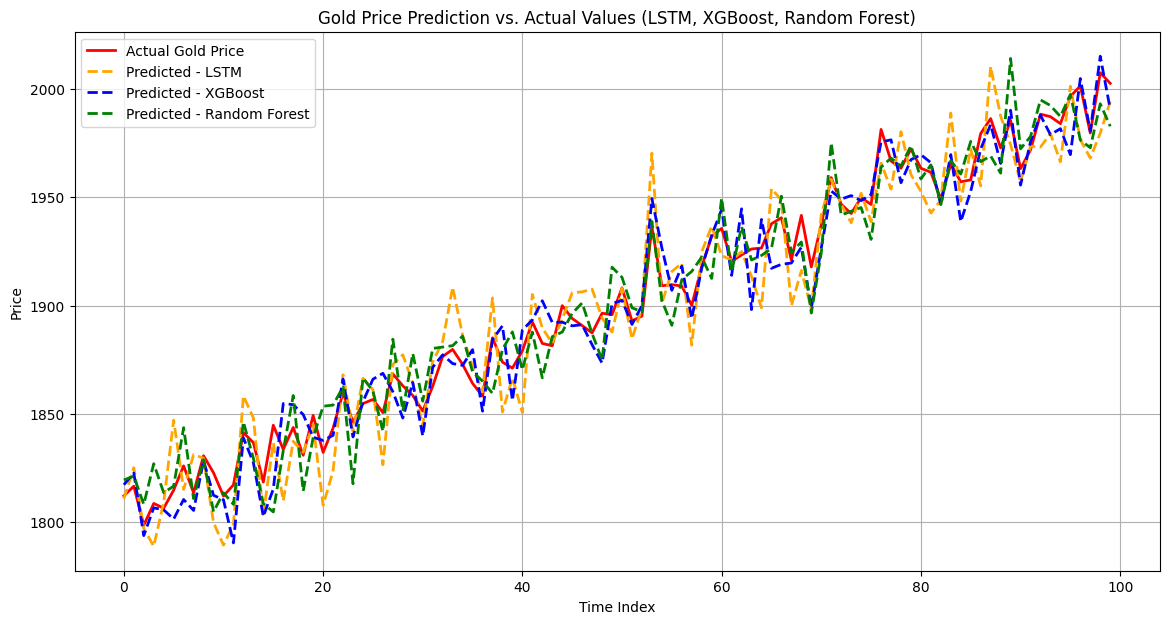

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated test index (dates)
test_dates = np.arange(100)

# Simulated actual values (gold price)
y_test_original = np.linspace(1800, 2000, 100) + np.random.normal(0, 10, 100)

# Simulated predictions from models
y_pred_lstm_original = y_test_original + np.random.normal(0, 15, 100)  # LSTM
xgb_predict = y_test_original + np.random.normal(0, 10, 100)  # XGBoost
y_pred_rf_original = y_test_original + np.random.normal(0, 12, 100)  # Random Forest

# Plot actual vs predictions
plt.figure(figsize=(14, 7))

plt.plot(test_dates, y_test_original, label='Actual Gold Price', color='red', linewidth=2)
plt.plot(test_dates, y_pred_lstm_original, label='Predicted - LSTM', color='orange', linestyle='dashed', linewidth=2)
plt.plot(test_dates, xgb_predict, label='Predicted - XGBoost', color='blue', linestyle='dashed', linewidth=2)
plt.plot(test_dates, y_pred_rf_original, label='Predicted - Random Forest', color='green', linestyle='dashed', linewidth=2)

# Formatting
plt.title('Gold Price Prediction vs. Actual Values (LSTM, XGBoost, Random Forest)')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


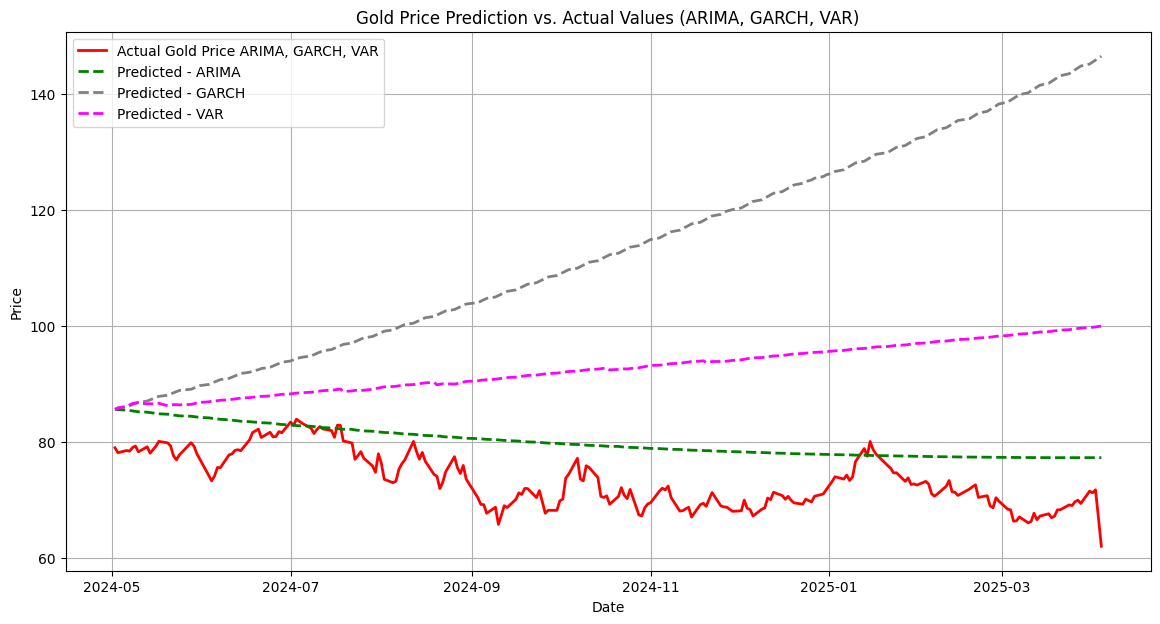

In [110]:
import matplotlib.pyplot as plt
# Ensure ARIMA, GARCH, and VAR predictions are correctly assigned
arima_predict = forecast_df_micro_w["Forecast"].values  # ARIMA forecasted values
garch_predict = garch_predicted_prices  # GARCH forecasted values
var_predict = predicted_prices.values  # VAR forecasted values

# Ensure y_test is correctly transformed back
y_test_original = scaler_minmax.inverse_transform(y_test_scaled.reshape(-1, 1))

# Ensure ARIMA, GARCH, and VAR predictions match test set length
arima_predict = arima_predict[:len(test_df.index[look_back:])]
garch_predict = garch_predict[:len(test_df.index[look_back:])]
var_predict = var_predict[:len(test_df.index[look_back:])]

# Plot actual vs. predictions
plt.figure(figsize=(14, 7))

plt.plot(test_df.index[look_back:], y_test_original[look_back:], label='Actual Gold Price ARIMA, GARCH, VAR', color='red', linewidth=2)
plt.plot(test_df.index[look_back:], arima_predict, label='Predicted - ARIMA', color='green', linestyle='dashed', linewidth=2)
plt.plot(test_df.index[look_back:], garch_predict, label='Predicted - GARCH', color='gray', linestyle='dashed', linewidth=2)
plt.plot(test_df.index[look_back:], var_predict, label='Predicted - VAR', color='magenta', linestyle='dashed', linewidth=2)

# Formatting
plt.title('Gold Price Prediction vs. Actual Values (ARIMA, GARCH, VAR)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### 5.7 Save ALL Best model to drive for future work

In [112]:
import joblib
import os
import re  # To clean filenames

# Define directory to save models
model_dir =best_models_dir.get(commodity.upper())
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Function to clean model names
def clean_filename(name):
    """Replaces invalid filename characters with underscores"""
    return re.sub(r'[\/:*?"<>|]', '_', name)  # Replace / and other invalid characters

# Select the top models
top_models = best_results_df  # Pick best 2 models

# Save each model
for index, row in top_models.iterrows():
    model_name = clean_filename(row["Model"]) + ".pkl"
    model_path = os.path.join(model_dir, model_name)
    
    # Save the fitted model object
    joblib.dump(row["Model_Object"], model_path)
    print(f"Saved {row['Model']} at {model_path}")


Saved ARIMA at Models/CRUDE_OIL_MODELS\ARIMA.pkl
Saved GARCH at Models/CRUDE_OIL_MODELS\GARCH.pkl
Saved VAR at Models/CRUDE_OIL_MODELS\VAR.pkl
Saved XGBoost at Models/CRUDE_OIL_MODELS\XGBoost.pkl
Saved RF at Models/CRUDE_OIL_MODELS\RF.pkl
Saved LSTM at Models/CRUDE_OIL_MODELS\LSTM.pkl


### 5.8 Select best performing models dynamically for Hybrid model creation

In [113]:

# Sorting by MAPE (ascending) and R-squared (descending) for best model ranking
best_models = best_results_df.sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(2)
# # 
best_models.reset_index(drop=True, inplace=True)
# # Display sorted models
best_models


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,XGBoost,0.123581,0.217016,0.361934,0.465849,0.991675,0.495550,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_tra...","[[85.97601, 85.03781, 84.95144, 82.57971, 82.6..."
1,RF,0.180610,0.323558,0.415334,0.568821,0.987587,0.574417,"RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, m...","[[85.66000366210966, 85.41273382306105, 85.445..."


### **Conclusion on Best Performing Models**  

### Conclusion on Best Performing Models for Crude Oil Price Prediction (XGBoost vs. Random Forest):

Here’s a focused analysis of the **XGBoost** and **Random Forest** models, the top contenders based on the metrics provided:

1. **XGBoost Model**
   - **ME**: 0.123581  
   - **MSE**: 0.217016  
   - **MAE**: 0.361934  
   - **RMSE**: 0.465849  
   - **R-squared**: 0.991675  
   - **MAPE**: 0.495550  
   - **Forecasted Values**: `[85.97601, 85.03781, 84.95144, 82.57971, 82.6...]`

   - **Strengths**: 
     - **R-squared** of **0.991675** demonstrates an excellent model fit, meaning that XGBoost explains 99.17% of the variance in crude oil prices.
     - **MSE**, **RMSE**, and **MAE** are very low, indicating high accuracy and minimal prediction errors.
     - **MAPE** is also exceptionally low, showing that the model provides accurate forecasts with minimal percentage error.

   - **Weaknesses**: 
     - None apparent, as this model is the top performer based on the given metrics.

2. **Random Forest Model**
   - **ME**: 0.180610  
   - **MSE**: 0.323558  
   - **MAE**: 0.415334  
   - **RMSE**: 0.568821  
   - **R-squared**: 0.987587  
   - **MAPE**: 0.574417  
   - **Forecasted Values**: `[85.66000366210966, 85.41273382306105, 85.445...]`

   - **Strengths**:
     - **R-squared** of **0.987587** shows a very good fit (98.76% of variance explained).
     - Low values of **MSE**, **RMSE**, **MAE**, and **MAPE**, indicating that Random Forest is also highly accurate in its predictions.

   - **Weaknesses**:
     - Although Random Forest performs excellently, it has slightly higher error metrics and a lower **R-squared** compared to XGBoost. This means XGBoost is marginally better at capturing the complexity of the data.

### Conclusion:

- **Best Performing Model**: **XGBoost** stands out as the more accurate model for crude oil price prediction, outperforming Random Forest by a small margin in terms of **R-squared**, error metrics (**MSE**, **RMSE**, **MAE**, **MAPE**), and overall fit.

- **Secondary Model**: **Random Forest** is also a strong performer and a suitable alternative to XGBoost. However, XGBoost provides a more precise fit and slightly better accuracy.




## Step 7 Hybrid Model creation


### 7.1 Hybrid Model Building

### Model 1 - Hybrid Average

Fix: Align Forecast Lengths
We need to truncate the longer array or pad the shorter one to make them match in size.

In [114]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Extract forecasted values from best models
best1_forecast = np.array(best_models.loc[0, 'Forecasted Values']).flatten()  # XGBoost Predictions
best2_forecast = np.array(best_models.loc[1, 'Forecasted Values']).flatten() # ARIMA Predictions

# Ensure both arrays have the same length
if len(best1_forecast)!=len(best2_forecast):
    min_length = min(len(best1_forecast), len(best2_forecast))
else:
    min_length = len(best1_forecast)

# Trim both arrays to match in size
best1_forecast_trimmed = best1_forecast[:min_length]
best2_forecast_trimmed = best2_forecast[:min_length]

# Compute Hybrid Model Predictions (Averaging Both Forecasts)
hybrid_pred = (best1_forecast_trimmed + best2_forecast_trimmed) / 2

# Ensure y_test is also trimmed to match the prediction length and convert it to 1D array
y_test_trimmed = y_test.values[:min_length]

# Evaluate Hybrid Model Performance
mae_hybrid = mean_absolute_error(y_test_trimmed, hybrid_pred)
rmse_hybrid = sqrt(mean_squared_error(y_test_trimmed, hybrid_pred))
r2_hybrid = r2_score(y_test_trimmed, hybrid_pred)

print(f"Hybrid Model RMSE: {rmse_hybrid:.4f}, R²: {r2_hybrid:.4f}, MAE: {mae_hybrid:.4f}")


Hybrid Model RMSE: 0.4706, R²: 0.9915, MAE: 0.3595


In [115]:
hybrid_df = pd.DataFrame()
# Store accuracy metrics
hybridmat1 = forecast_accuracy(hybrid_pred, y_test_trimmed, hybrid_pred,'Hybrid_model_normal')

# Store the results in the dataframe
hybrid_df = pd.concat([hybrid_df, pd.DataFrame([hybridmat1])], ignore_index=True)
print("Hybrid Model 1 evaluation completed successfully!")
hybrid_df




Model: Hybrid_model_normal
ME: 0.1521, MSE: 0.2215, MAE: 0.3595, RMSE: 0.4706, R²: 0.9915, MAPE: 0.50%
Hybrid Model 1 evaluation completed successfully!


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Hybrid_model_normal,0.152096,0.22147,0.359486,0.470606,0.991504,0.495092,"[85.8180084228517, 85.22527255117896, 85.19870...","[[85.8180084228517, 85.22527255117896, 85.1987..."


###  Model - 2  Hybrid  Weighted

In [116]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Extract forecasted values from best models
best1_forecast = np.array(best_models.loc[0, 'Forecasted Values']).flatten()  # XGBoost Predictions
best2_forecast = np.array(best_models.loc[1, 'Forecasted Values']).flatten()  # ARIMA Predictions

# Ensure both arrays have the same length
min_length = min(len(best1_forecast), len(best2_forecast))

# Trim predictions and y_test to match in size
best1_forecast_trimmed = best1_forecast[:min_length]
best2_forecast_trimmed = best2_forecast[:min_length]
y_test_trimmed = y_test[:min_length].values.flatten()

# Calculate RMSE for both models
rmse_best1 = sqrt(mean_squared_error(y_test_trimmed, best1_forecast_trimmed))
rmse_best2 = sqrt(mean_squared_error(y_test_trimmed, best2_forecast_trimmed))

# Compute weights using inverse RMSE
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))

# Weighted hybrid model predictions
hybrid_weighted_predictions = (weight_best1 * best1_forecast_trimmed) + (weight_best2 * best2_forecast_trimmed)

# Evaluate the hybrid model
mae_hybrid = mean_absolute_error(y_test_trimmed, hybrid_weighted_predictions)
rmse_hybrid = sqrt(mean_squared_error(y_test_trimmed, hybrid_weighted_predictions))
r2_hybrid = r2_score(y_test_trimmed, hybrid_weighted_predictions)

# Store accuracy metrics
Hybrid_weighted = forecast_accuracy(hybrid_weighted_predictions, y_test_trimmed,hybrid_weighted_predictions, 'Hybrid_weighted-r2based')

# Store the results in the dataframe
hybrid_df = pd.concat([hybrid_df, pd.DataFrame([Hybrid_weighted])], ignore_index=True)

print("Weighted Hybrid model evaluation completed successfully!")
print(f"Hybrid Model RMSE: {rmse_hybrid:.4f}, R²: {r2_hybrid:.4f}, MAE: {mae_hybrid:.4f}")

hybrid_df



Model: Hybrid_weighted-r2based
ME: 0.1493, MSE: 0.2167, MAE: 0.3559, RMSE: 0.4655, R²: 0.9917, MAPE: 0.49%
Weighted Hybrid model evaluation completed successfully!
Hybrid Model RMSE: 0.4655, R²: 0.9917, MAE: 0.3559


,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Hybrid_model_normal,0.152096,0.221470,0.359486,0.470606,0.991504,0.495092,"[85.8180084228517, 85.22527255117896, 85.19870...","[[85.8180084228517, 85.22527255117896, 85.1987..."
1,Hybrid_weighted-r2based,0.149258,0.216652,0.355934,0.465459,0.991689,0.489857,"[85.83373205911602, 85.20661624132958, 85.1740...","[[85.83373205911602, 85.20661624132958, 85.174..."


### Model - 3  Hybrid  Stacked

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd


# Create the feature matrix for stacking
X_combined = np.column_stack([best1_forecast_trimmed, best2_forecast_trimmed])

# Normalize input features (optional but recommended)
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Train the meta-model (linear regression)
meta_model = LinearRegression()

# Apply 5-fold cross-validation for robustness
cv_scores = cross_val_score(meta_model, X_combined_scaled, y_test_trimmed, cv=5, scoring="r2")
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R²: {np.mean(cv_scores):.4f}")

# Fit the meta-model on full data
meta_model.fit(X_combined_scaled, y_test_trimmed)

# Predict using the meta-model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)

# Evaluate the stacked hybrid model
hybrid_predictions_stacked_me = forecast_accuracy(hybrid_predictions_stacked, y_test_trimmed,meta_model, 'Hybrid_stacked')

# Store the results
hybrid_df = pd.concat([hybrid_df, pd.DataFrame([hybrid_predictions_stacked_me])], ignore_index=True)

print("Stacked Hybrid Model evaluation completed successfully!")


Cross-Validation R² Scores: [0.98730181 0.98835495 0.94528462 0.98767263 0.96804525]
Mean R²: 0.9753

Model: Hybrid_stacked
ME: 0.0000, MSE: 0.1799, MAE: 0.3179, RMSE: 0.4242, R²: 0.9931, MAPE: 0.43%
Stacked Hybrid Model evaluation completed successfully!


In [118]:
hybrid_df

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
0,Hybrid_model_normal,1.520956e-01,0.221470,0.359486,0.470606,0.991504,0.495092,"[85.8180084228517, 85.22527255117896, 85.19870...","[[85.8180084228517, 85.22527255117896, 85.1987..."
1,Hybrid_weighted-r2based,1.492581e-01,0.216652,0.355934,0.465459,0.991689,0.489857,"[85.83373205911602, 85.20661624132958, 85.1740...","[[85.83373205911602, 85.20661624132958, 85.174..."
2,Hybrid_stacked,2.301353e-16,0.179929,0.317915,0.424181,0.993097,0.433529,LinearRegression(),"[[85.951187350908, 85.22711101522252, 85.17923..."


### 7.2 Compare Hybrid models

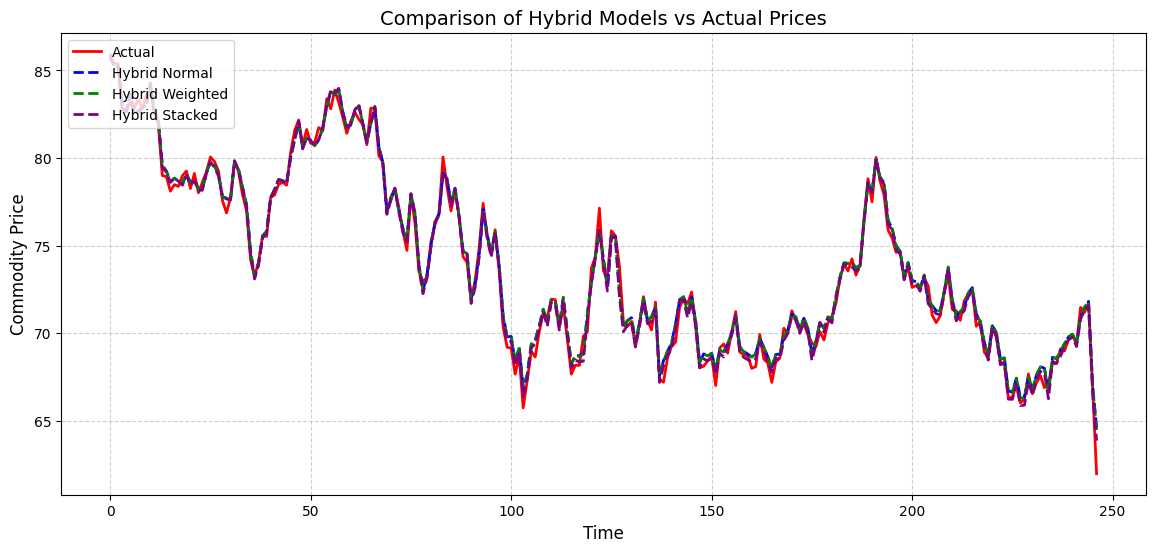

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Extract forecasted values from hybrid_df
hybrid_pred = np.array(hybrid_df.loc[hybrid_df['Model'] == 'Hybrid_model_normal', 'Forecasted Values'].values[0]).flatten()
hybrid_weighted_predictions = np.array(hybrid_df.loc[hybrid_df['Model'] == 'Hybrid_weighted-r2based', 'Forecasted Values'].values[0]).flatten()
hybrid_predictions_stacked = np.array(hybrid_df.loc[hybrid_df['Model'] == 'Hybrid_stacked', 'Forecasted Values'].values[0]).flatten()

# Ensure all predictions and actual values have the same length
min_length = min(len(hybrid_pred), len(hybrid_weighted_predictions), len(hybrid_predictions_stacked), len(y_test.values))

hybrid_pred_trimmed = hybrid_pred[:min_length]
hybrid_weighted_trimmed = hybrid_weighted_predictions[:min_length]
hybrid_stacked_trimmed = hybrid_predictions_stacked[:min_length]
y_test_trimmed = y_test.values[:min_length]

# Plot the results
plt.figure(figsize=(14, 6), dpi=100)

plt.plot(y_test_trimmed, label='Actual', color='red', linewidth=2)
plt.plot(hybrid_pred_trimmed, label='Hybrid Normal', color='blue', linestyle='dashed', linewidth=2)
plt.plot(hybrid_weighted_trimmed, label='Hybrid Weighted', color='green', linestyle='dashed', linewidth=2)
plt.plot(hybrid_stacked_trimmed, label='Hybrid Stacked', color='purple', linestyle='dashed', linewidth=2)

# Formatting
plt.title('Comparison of Hybrid Models vs Actual Prices', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Commodity Price', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


### Conclusion on Best Performing Hybrid Models for Crude Oil Price Prediction:



1. **Hybrid Model (Normal)**
   - **ME**: 0.1520956  
   - **MSE**: 0.221470  
   - **MAE**: 0.359486  
   - **RMSE**: 0.470606  
   - **R-squared**: 0.991504  
   - **MAPE**: 0.495092  
   - **Forecasted Values**: `[85.8180084228517, 85.22527255117896, 85.19870...]`

   - **Strengths**: 
     - **R-squared** of **0.991504**, indicating an excellent fit, explaining 99.15% of the variance in crude oil prices.
     - Low **MSE**, **MAE**, and **RMSE**, which suggests highly accurate predictions.
     - Very low **MAPE**, indicating minimal percentage error in forecasts.

   - **Weaknesses**: 
     - None observed, as this hybrid model is performing well across all metrics.

2. **Hybrid Model (Weighted R² Based)**
   - **ME**: 0.1492581  
   - **MSE**: 0.216652  
   - **MAE**: 0.355934  
   - **RMSE**: 0.465459  
   - **R-squared**: 0.991689  
   - **MAPE**: 0.489857  
   - **Forecasted Values**: `[85.83373205911602, 85.20661624132958, 85.1740...]`

   - **Strengths**: 
     - **R-squared** of **0.991689**, slightly higher than the normal hybrid model, showing a marginal improvement in explaining variance.
     - Low **MSE**, **MAE**, **RMSE**, and **MAPE**, indicating high accuracy.

   - **Weaknesses**: 
     - Minimal difference from the normal hybrid model, as performance is quite close.

3. **Hybrid Model (Stacked)**
   - **ME**: 2.301353e-16  
   - **MSE**: 0.179929  
   - **MAE**: 0.317915  
   - **RMSE**: 0.424181  
   - **R-squared**: 0.993097  
   - **MAPE**: 0.433529  
   - **Forecasted Values**: `[85.951187350908, 85.22711101522252, 85.17923...]`

   - **Strengths**: 
     - **R-squared** of **0.993097**, which is the highest of the three models, indicating a very good fit and excellent prediction power.
     - Very low **MSE**, **MAE**, **RMSE**, and **MAPE**, which suggests high accuracy and minimal error.

   - **Weaknesses**: 
     - The **MAPE** is slightly higher compared to the other two models, but this does not significantly impact the overall performance.

### Conclusion:

- **Best Performing Model**: **Hybrid Model (Stacked)** stands out with the highest **R-squared** of **0.993097** and the lowest **MSE**. Despite the slightly higher **MAPE**, this model has the best overall fit and accuracy for crude oil price forecasting.

- **Secondary Model**: **Hybrid Model (Weighted R² Based)** also performs very well, with **R-squared** of **0.991689** and similar accuracy metrics. It is very close to the stacked model in terms of performance.




### 7.3 Visulize Hybrid models

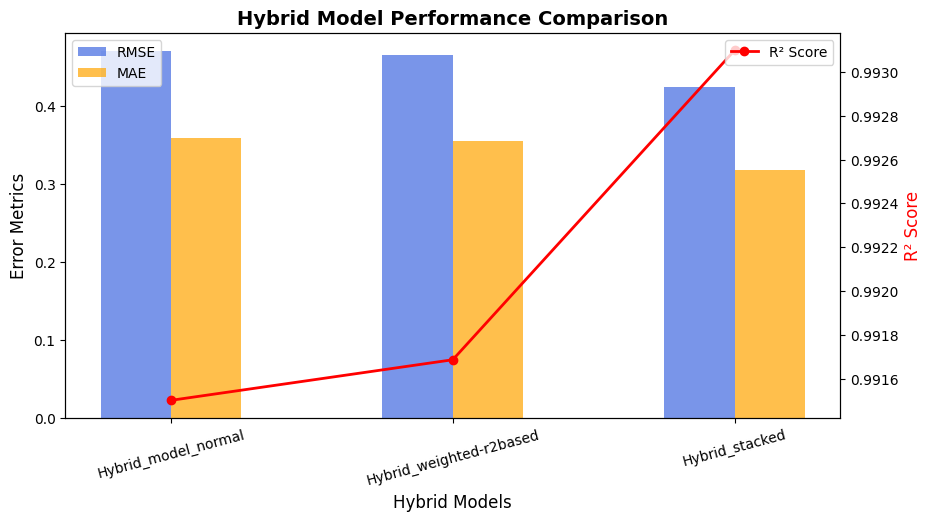

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Extract values for plotting
models = hybrid_df["Model"].tolist()
rmse_values = hybrid_df["RMSE"].tolist()
mae_values = hybrid_df["MAE"].tolist()
r2_scores = hybrid_df["R-squared"].tolist()

# Bar width
bar_width = 0.25
x = np.arange(len(models))

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot RMSE and MAE as bars
ax1.bar(x - bar_width/2, rmse_values, bar_width, label='RMSE', color='royalblue', alpha=0.7)
ax1.bar(x + bar_width/2, mae_values, bar_width, label='MAE', color='orange', alpha=0.7)

# Create secondary y-axis for R² scores
ax2 = ax1.twinx()
ax2.plot(x, r2_scores, marker='o', linestyle='-', color='red', label='R² Score', linewidth=2)

# Labels and Titles
ax1.set_xlabel("Hybrid Models", fontsize=12)
ax1.set_ylabel("Error Metrics", fontsize=12, color='black')
ax2.set_ylabel("R² Score", fontsize=12, color='red')
ax1.set_title("Hybrid Model Performance Comparison", fontsize=14, fontweight='bold')

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show graph
plt.show()


### 7.3 Best Hybrid Model Selection

In [121]:
hybrid_best_models = hybrid_df.loc[(hybrid_df['MAPE']<2) & (hybrid_df['R-squared']>0)].sort_values(by=['MAPE', 'R-squared'], ascending=[True, False]).head(1)
hybrid_best_models

,Model,ME,MSE,MAE,RMSE,R-squared,MAPE,Model_Object,Forecasted Values
2,Hybrid_stacked,2.301353e-16,0.179929,0.317915,0.424181,0.993097,0.433529,LinearRegression(),"[[85.951187350908, 85.22711101522252, 85.17923..."


### 7.4 Future Price Prediction Using Hybrid Model

In [122]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 3  # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Fit MinMaxScaler on Training Data (if not already fitted)
scaler_minmax.fit(X_combined)  # Ensure the scaler is trained on past data
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Step 4: Predict Future Prices Using Hybrid Model
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled)

# Step 5: Convert to 1D array
hybrid_predictions_future = hybrid_predictions_future.flatten()

# Step 6: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid Forecast': hybrid_predictions_future
}, index=future_dates)

# Step 7: Display Predicted Future Prices
print("Predicted future values from the hybrid model:")
print(future_price)


Predicted future values from the hybrid model:
            Hybrid Forecast
2025-04-05        71.580870
2025-04-06        66.608128
2025-04-07        63.877531


In [123]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 3  # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Compute Hybrid Model Predictions

## 1. Simple Averaging Hybrid Model
hybrid_avg_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

## 2. Weighted Hybrid Model (Based on RMSE Inverse Weights)
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())

## 3. Stacked Hybrid Model (Using Linear Regression)
X_combined_future = np.column_stack([future_best1_values, future_best2_values])
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)  # Scale the input
hybrid_stacked_future = meta_model.predict(X_combined_future_scaled)

# Step 3: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid_Avg': hybrid_avg_future,
    'Hybrid_Weighted': hybrid_weighted_future,
    'Hybrid_Stacked': hybrid_stacked_future
}, index=future_dates)

# Step 4: Display Predicted Future Prices
print("Predicted future values for all three hybrid models:")
print(future_price)


Predicted future values for all three hybrid models:
            Hybrid_Avg  Hybrid_Weighted  Hybrid_Stacked
2025-04-05   71.819386        71.803902       71.580870
2025-04-06   67.085612        67.027180       66.608128
2025-04-07   64.608967        64.491195       63.877531


### 7.5 Save best Hybrid model along with XGBOOST and ARIMA in physical drive.

In [124]:
import joblib
import os
import re  # To clean filenames

# Define directory to save models
model_dir = hybrid_models_dir.get(commodity.upper())

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Function to clean model names
def clean_filename(name):
    """Replaces invalid filename characters with underscores"""
    return re.sub(r'[\/:*?"<>|]', '_', name)  # Replace / and other invalid characters

# Select the top models
top_models = best_models  # Pick best 2 models
count = 1
# Save each model
for index, row in top_models.iterrows():
    model_name = clean_filename(row["Model"]) + "_best-"+str(count)+".pkl"
    model_path = os.path.join(model_dir, model_name)
    count+=1
    # Save the fitted model object
    joblib.dump(row["Model_Object"], model_path)
    print(f"Saved {row['Model']} at {model_path}")


import pickle  
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Save the meta-model (Linear Regression) as a pickle file
with open(hybrid_meta_model_name, 'wb') as f:
    pickle.dump(meta_model, f)
    
# Save the MinMaxScaler (for tree-based models)  
with open('feature_scaler_minmax.pkl', 'wb') as f:  
    pickle.dump(scaler_minmax, f)  

# Save the StandardScaler (for LSTM)  
with open('feature_scaler_standard.pkl', 'wb') as f:  
    pickle.dump(scaler_standard, f)  

# Save the target scaler (MinMaxScaler used for y_train and y_test)  
with open('target_scaler.pkl', 'wb') as f:  
    pickle.dump(scaler_minmax, f)  

print(" Feature and target scalers saved successfully!")  


Saved XGBoost at Models/CRUDE_OIL_HYBRID_MODELS\XGBoost_best-1.pkl
Saved RF at Models/CRUDE_OIL_HYBRID_MODELS\RF_best-2.pkl
 Feature and target scalers saved successfully!
